# Importing modules

In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
from sklearn import tree
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from pprint import pprint
from pandas.io.formats.style_render import DataFrame
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from math import ceil
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import *
import tensorflow as tf
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the dataset

In [ ]:
!cp /content/drive/Shareddrives/DM_Project/dataset/users_clustering.csv /content/
!cp /content/drive/Shareddrives/DM_Project/dataset/users_extended_clean.csv /content/

In [ ]:
# users = pd.read_csv("users_extended_clean.csv")
users = pd.read_csv("users_clustering.csv")

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11508 non-null  int64  
 1   name                    11508 non-null  object 
 2   lang                    11508 non-null  object 
 3   bot                     11508 non-null  int64  
 4   created_at              11508 non-null  object 
 5   statuses_count          11508 non-null  int64  
 6   reply_count_total       11508 non-null  float64
 7   favorite_count_total    11508 non-null  int64  
 8   num_hashtags_total      11508 non-null  int64  
 9   retweet_count_avg       11508 non-null  float64
 10  reply_count_avg         11508 non-null  float64
 11  favorite_count_avg      11508 non-null  float64
 12  num_hashtags_avg        11508 non-null  float64
 13  num_urls_avg            11508 non-null  float64
 14  num_mentions_avg        11508 non-null

# Check classes balance

In [ ]:
users["bot"].value_counts()/len(users)

1    0.531456
0    0.468544
Name: bot, dtype: float64

# Define functions to show the results

In [ ]:
def print_metrics(train_label, train_pred, test_label, test_pred):

  print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred))
  print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred))

  print('Precision train set ', metrics.precision_score(train_label, train_pred))
  print('Precision test set ', metrics.precision_score(test_label, test_pred))

  print('Recall train set ', metrics.recall_score(train_label, train_pred))
  print('Recall test set ', metrics.recall_score(test_label, test_pred))

  print('F1 score train set ', metrics.f1_score(train_label, train_pred))
  print('F1 score test set ', metrics.f1_score(test_label, test_pred))

  print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred)[3])
  print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred)[3])


def print_report(label, pred):
  print(classification_report(label, 
                              pred, 
                              target_names=['Real', 'Bot']))
  
def print_confusion_matrix(model, dataset, label):
  plot_confusion_matrix(model, dataset, label)
  plt.show()


def print_scatter(dataset, label, pred):
  pca = PCA(n_components=2)
  data = pca.fit_transform(dataset)
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].scatter(data[:, 0], data[:, 1], c=label, s=25, cmap='RdBu');
  ax[0].set_title("True labels")
  ax[1].scatter(data[:, 0], data[:, 1], c=pred, s=25, cmap='RdBu');
  ax[1].set_title("Predicted labels")
  plt.show()

# Apply log transformation to skewed distributions

In [ ]:
def visualize_distribution(col):

  data = users[col].copy()
  data_log = data.apply(lambda x: np.log10(x+1))

  data_real = users[users["bot"] == 0][col].copy()
  data_real_log = data_real.apply(lambda x: np.log10(x+1))

  data_bot = users[users["bot"] == 1][col].copy()
  data_bot_log = data_bot.apply(lambda x: np.log10(x+1))

  # print(f"\n{col} all users normal scale:")
  # fig, ax = plt.subplots(1, 2, figsize=(10,4))
  # fig.tight_layout()
  # ax[0].hist(data, bins=10)
  # ax[1].boxplot(data)
  # plt.show()

  # print(f"\n{col} all users log scale:")
  # fig, ax = plt.subplots(1, 2, figsize=(10,4))
  # fig.tight_layout()
  # ax[0].hist(data_log, bins=10)
  # ax[1].boxplot(data_log)
  # plt.show()


  print(f"\n{col} histogram normal scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(data_real, bins=10)
  ax[1].hist(data_bot, bins=10)
  plt.show()

  print(f"\n{col} histogram log scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(data_real_log, bins=10)
  ax[1].hist(data_bot_log, bins=10)
  plt.show()


  print(f"\n{col} boxplot normal scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(data_real)
  ax[1].boxplot(data_bot)
  plt.show()



  print(f"\n{col} boxplot log scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(data_real_log)
  ax[1].boxplot(data_bot_log)
  plt.show()


  del data
  del data_real
  del data_bot
  del data_log
  del data_real_log
  del data_bot_log


statuses_count histogram normal scale:


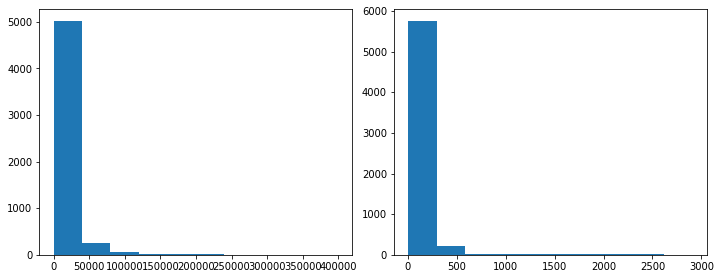


statuses_count histogram log scale:


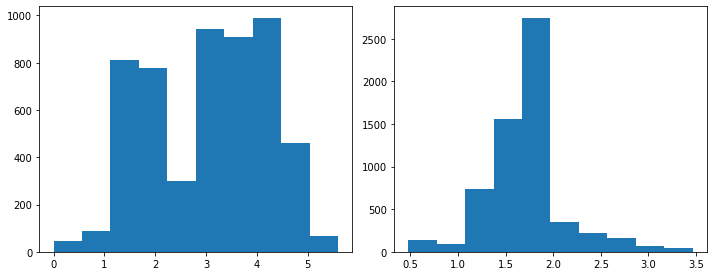


statuses_count boxplot normal scale:


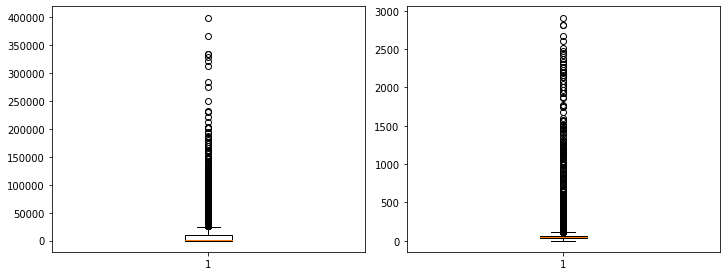


statuses_count boxplot log scale:


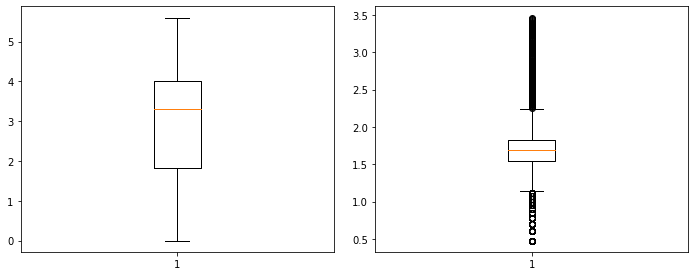






reply_count_total histogram normal scale:


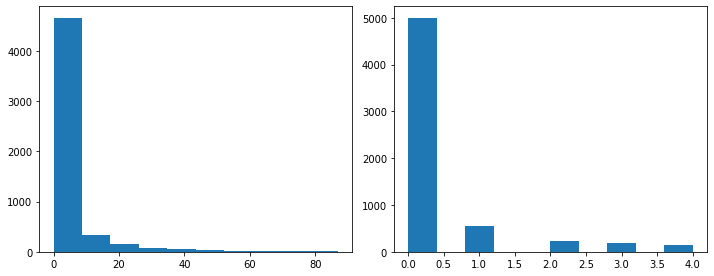


reply_count_total histogram log scale:


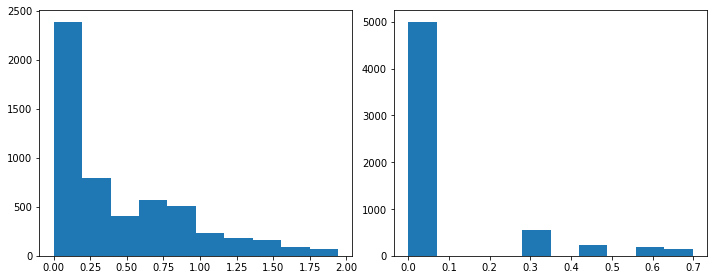


reply_count_total boxplot normal scale:


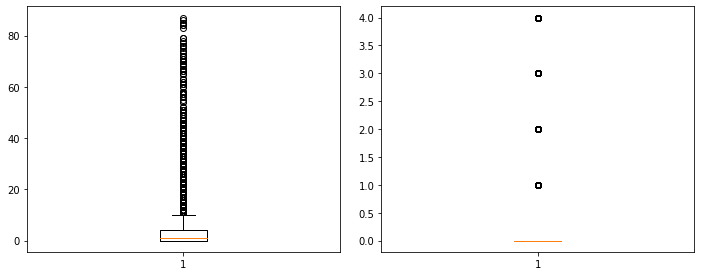


reply_count_total boxplot log scale:


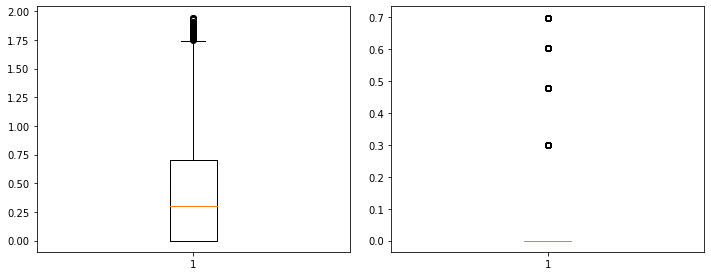






favorite_count_total histogram normal scale:


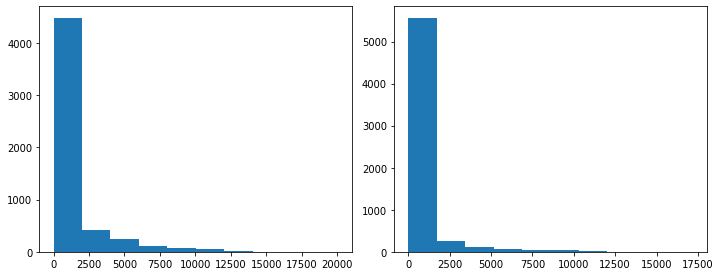


favorite_count_total histogram log scale:


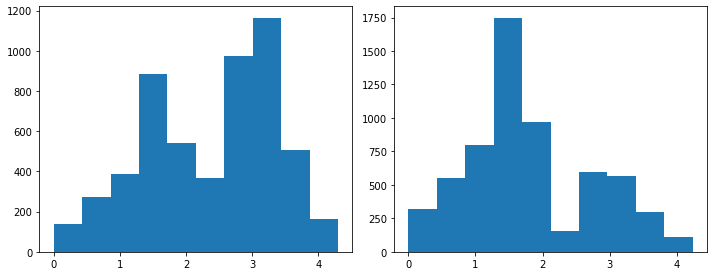


favorite_count_total boxplot normal scale:


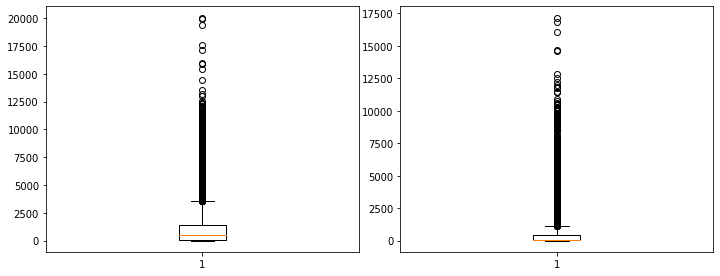


favorite_count_total boxplot log scale:


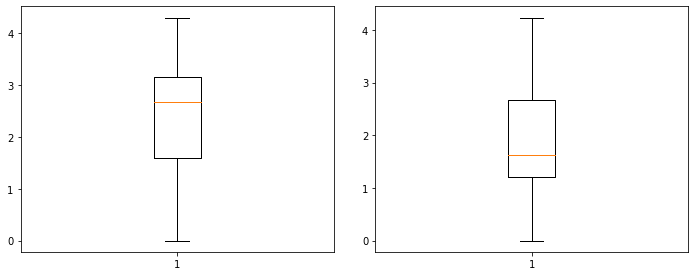






num_hashtags_total histogram normal scale:


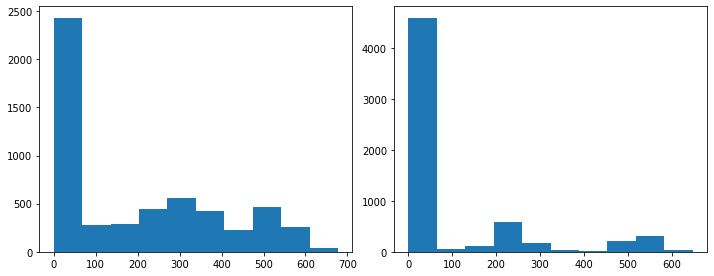


num_hashtags_total histogram log scale:


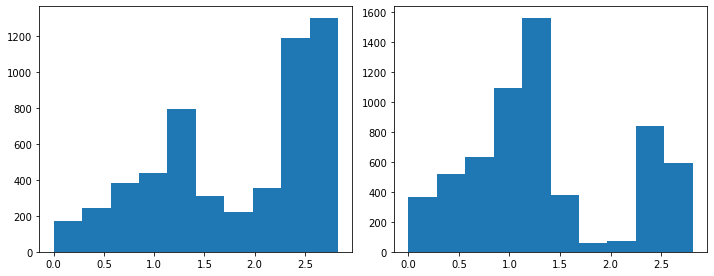


num_hashtags_total boxplot normal scale:


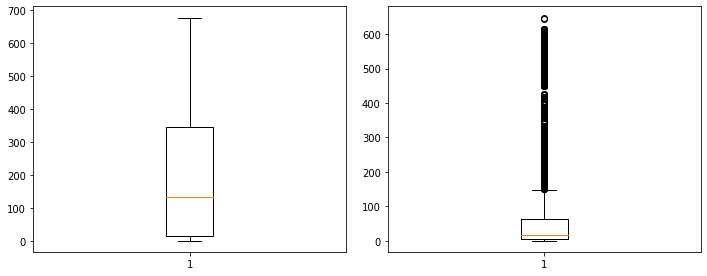


num_hashtags_total boxplot log scale:


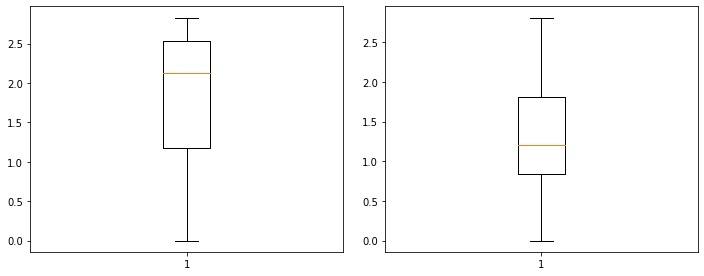






retweet_count_avg histogram normal scale:


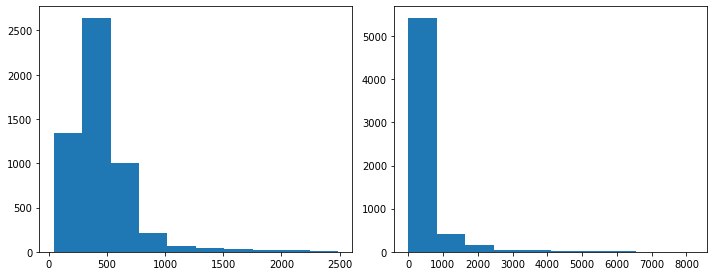


retweet_count_avg histogram log scale:


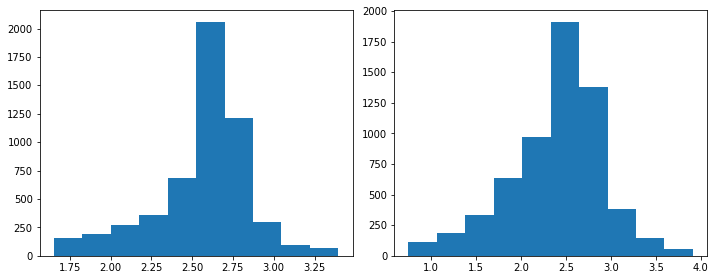


retweet_count_avg boxplot normal scale:


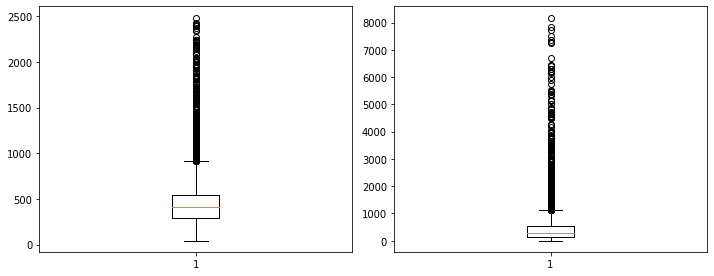


retweet_count_avg boxplot log scale:


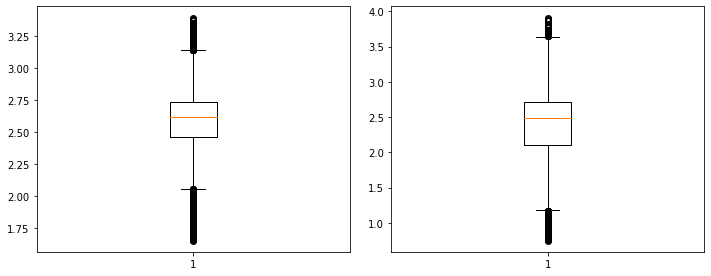






reply_count_avg histogram normal scale:


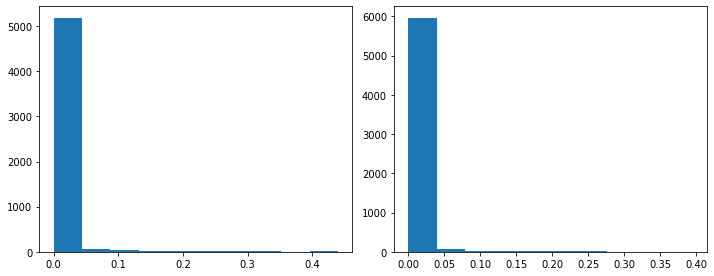


reply_count_avg histogram log scale:


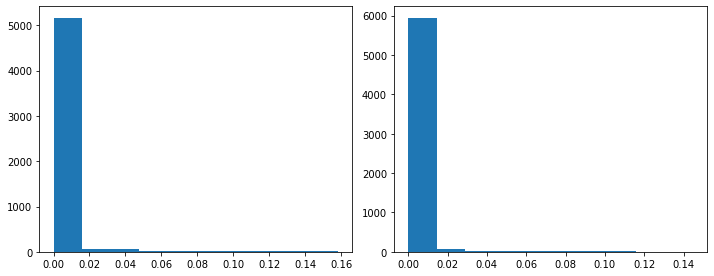


reply_count_avg boxplot normal scale:


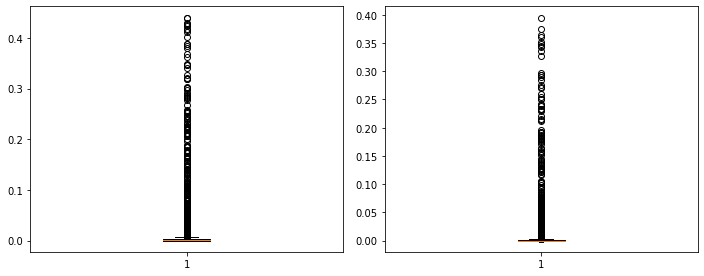


reply_count_avg boxplot log scale:


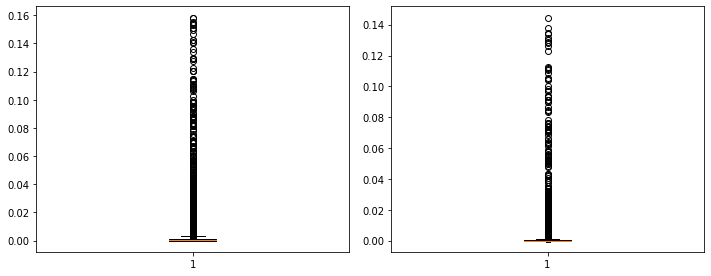






favorite_count_avg histogram normal scale:


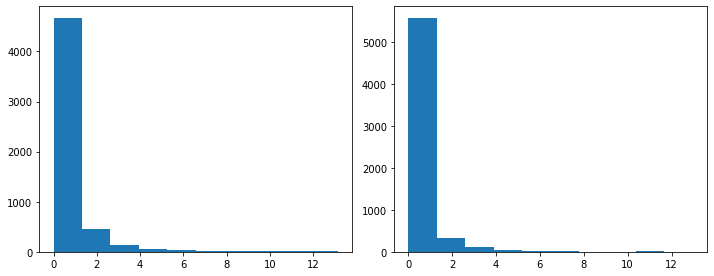


favorite_count_avg histogram log scale:


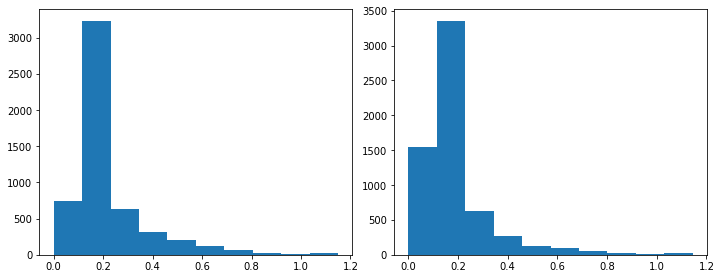


favorite_count_avg boxplot normal scale:


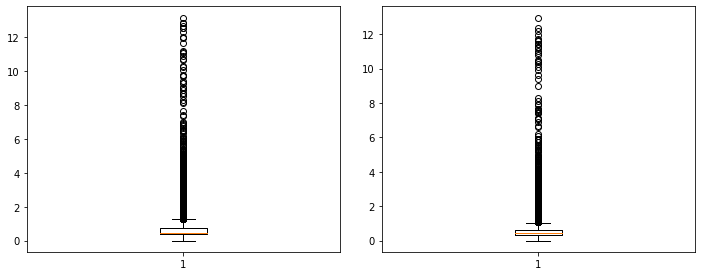


favorite_count_avg boxplot log scale:


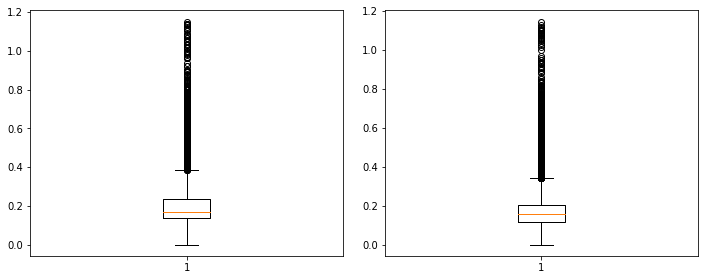






num_hashtags_avg histogram normal scale:


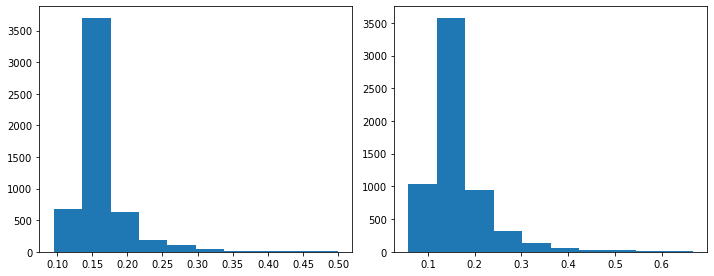


num_hashtags_avg histogram log scale:


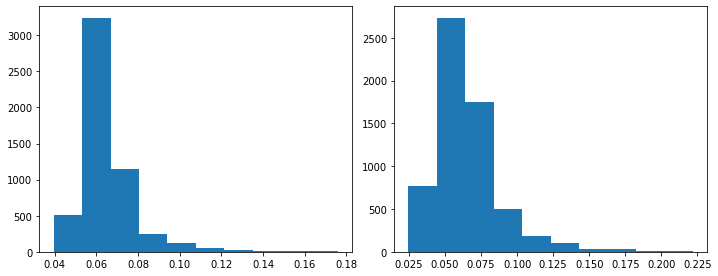


num_hashtags_avg boxplot normal scale:


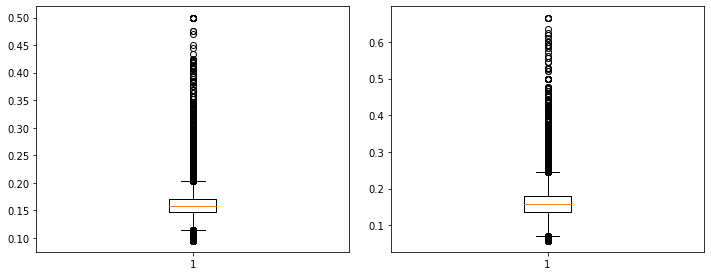


num_hashtags_avg boxplot log scale:


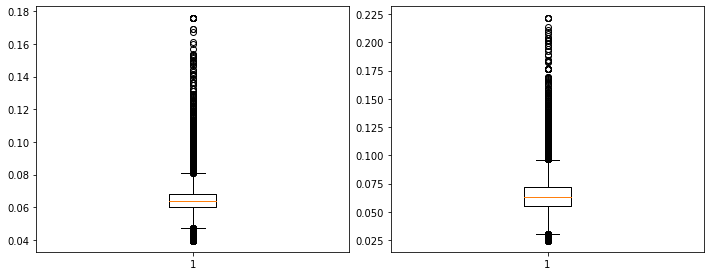






num_urls_avg histogram normal scale:


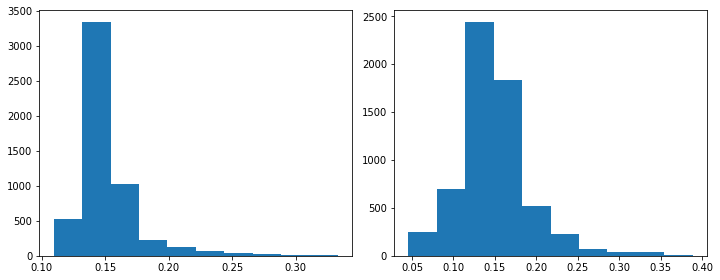


num_urls_avg histogram log scale:


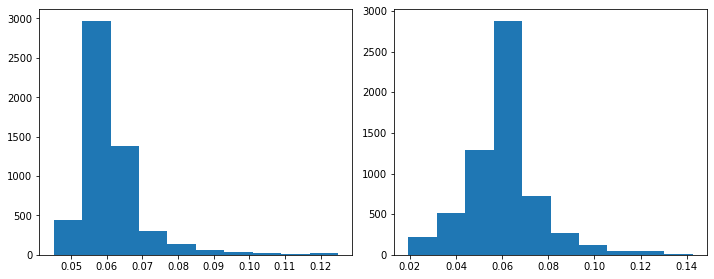


num_urls_avg boxplot normal scale:


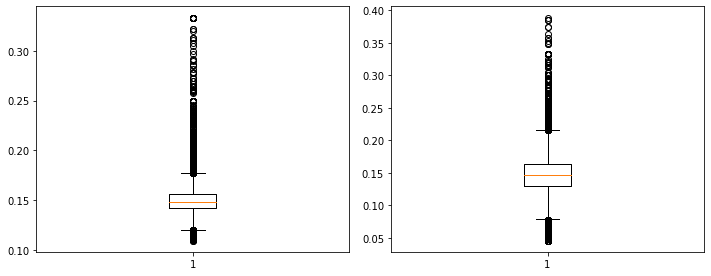


num_urls_avg boxplot log scale:


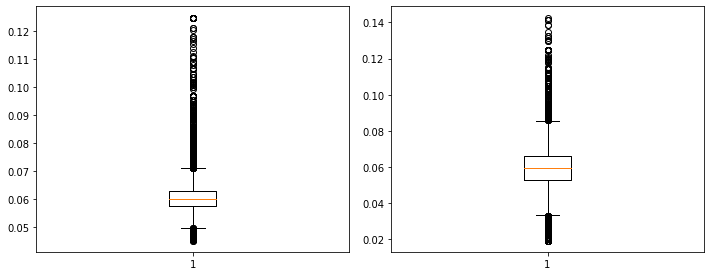






num_mentions_avg histogram normal scale:


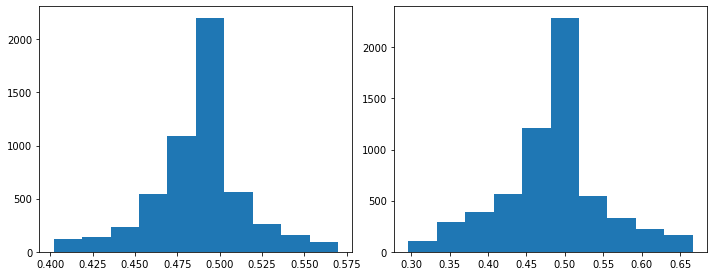


num_mentions_avg histogram log scale:


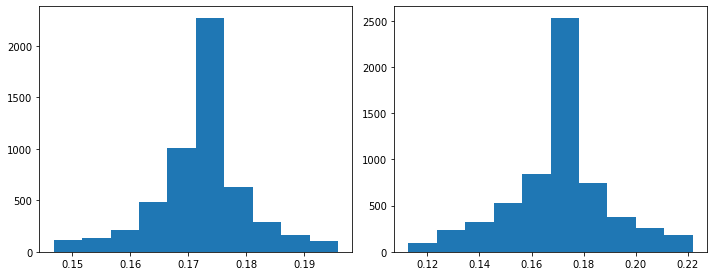


num_mentions_avg boxplot normal scale:


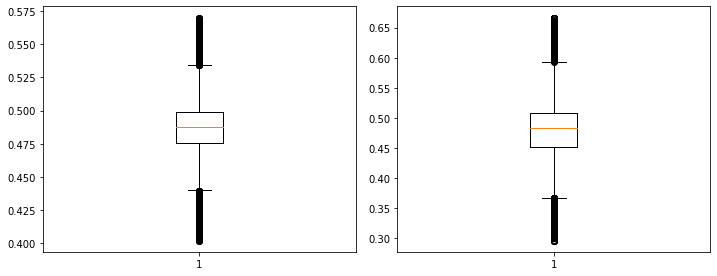


num_mentions_avg boxplot log scale:


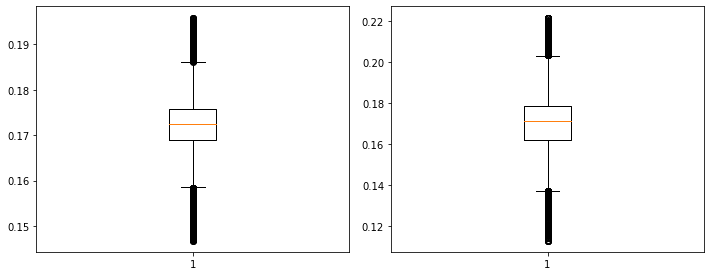






retweet_count_std histogram normal scale:


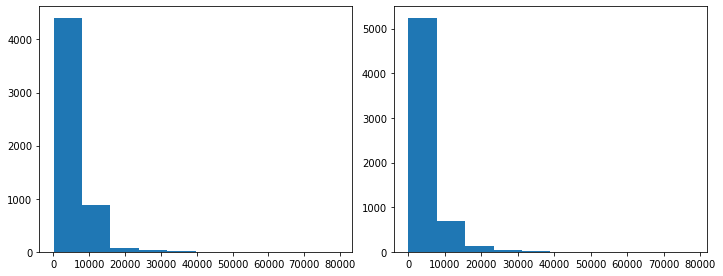


retweet_count_std histogram log scale:


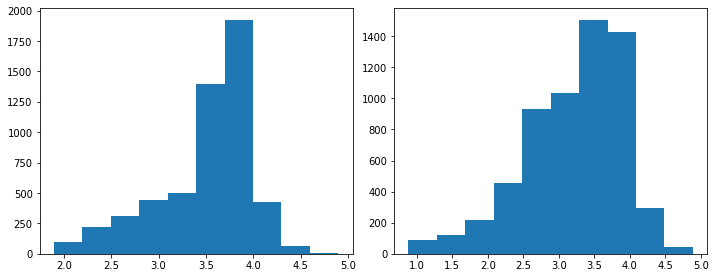


retweet_count_std boxplot normal scale:


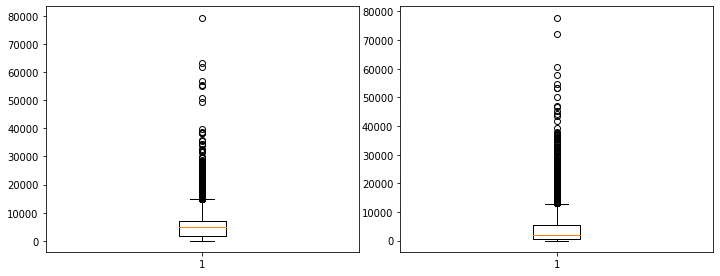


retweet_count_std boxplot log scale:


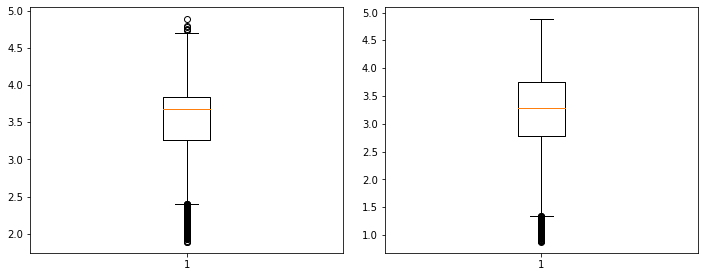






reply_count_std histogram normal scale:


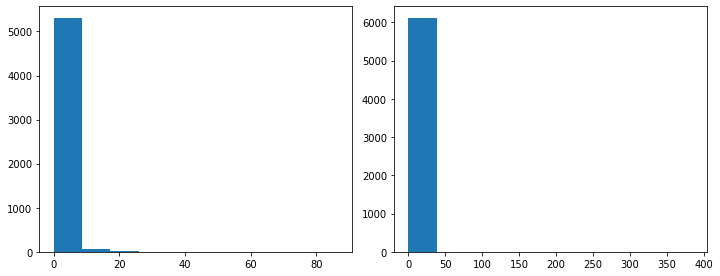


reply_count_std histogram log scale:


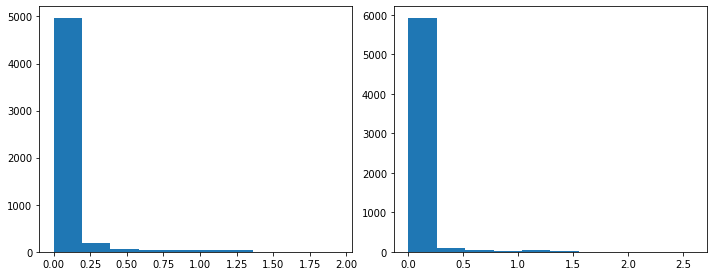


reply_count_std boxplot normal scale:


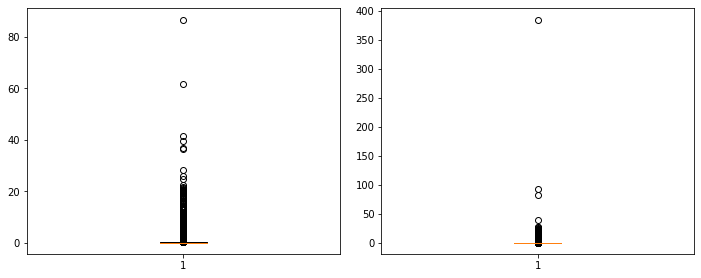


reply_count_std boxplot log scale:


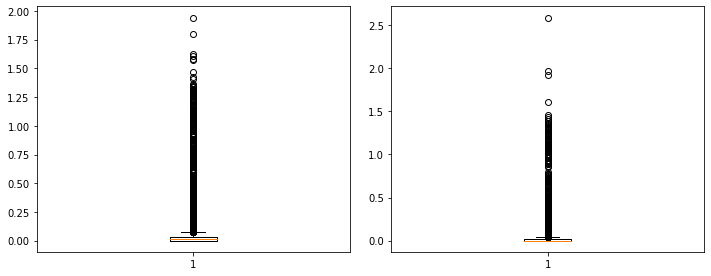






favorite_count_std histogram normal scale:


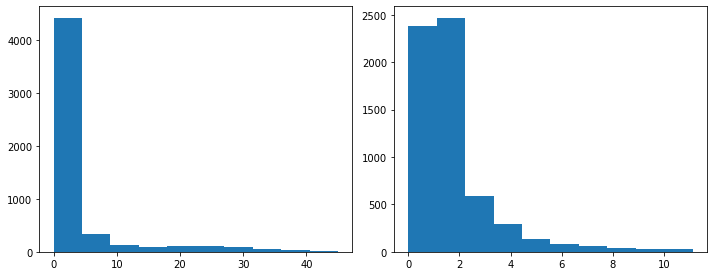


favorite_count_std histogram log scale:


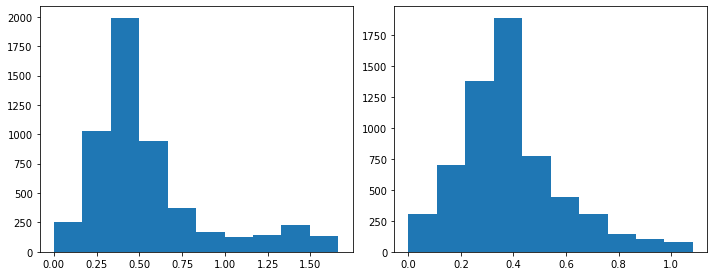


favorite_count_std boxplot normal scale:


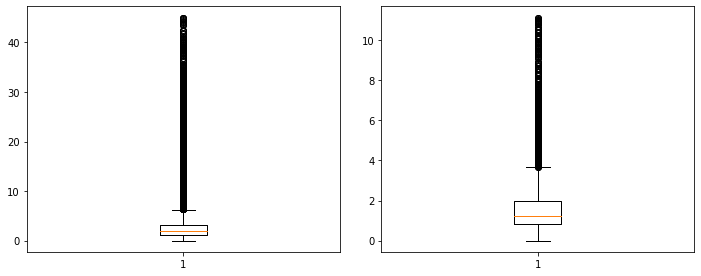


favorite_count_std boxplot log scale:


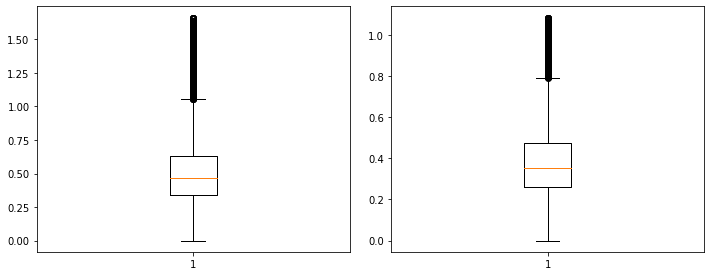






num_hashtags_std histogram normal scale:


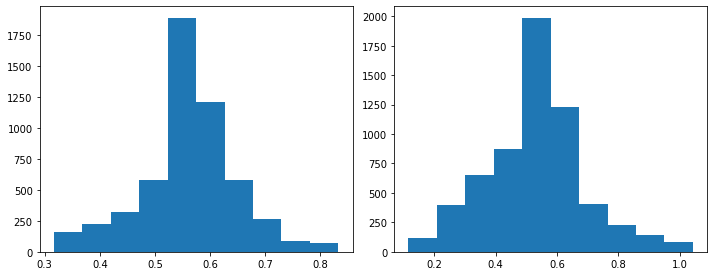


num_hashtags_std histogram log scale:


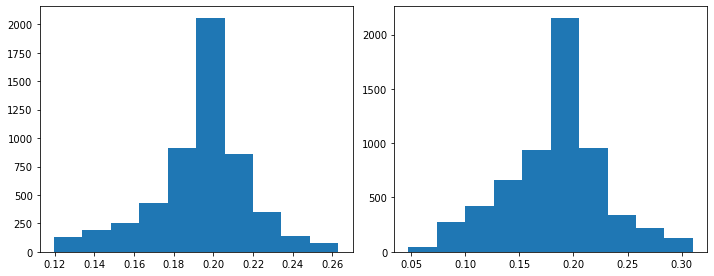


num_hashtags_std boxplot normal scale:


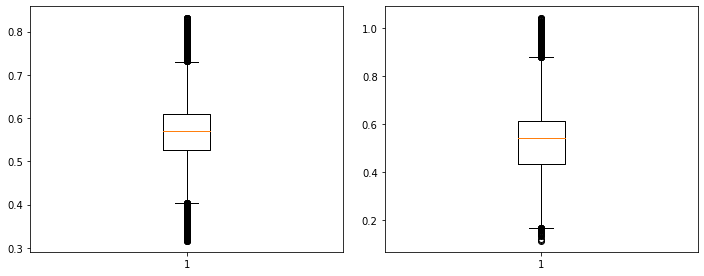


num_hashtags_std boxplot log scale:


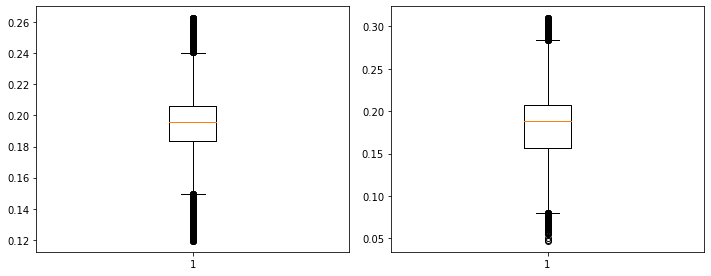






num_urls_std histogram normal scale:


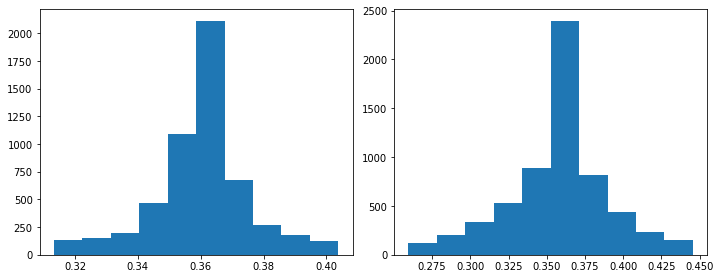


num_urls_std histogram log scale:


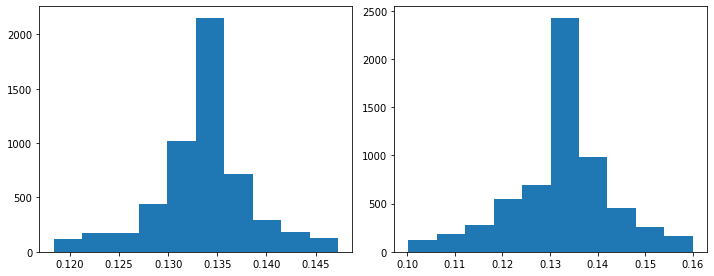


num_urls_std boxplot normal scale:


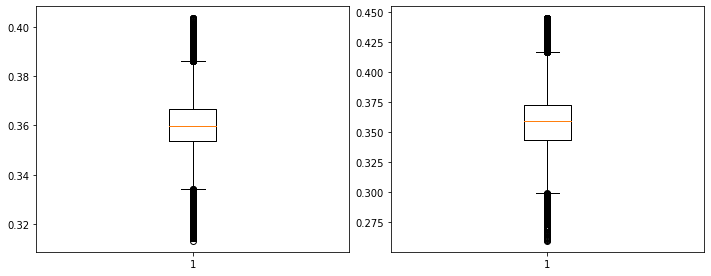


num_urls_std boxplot log scale:


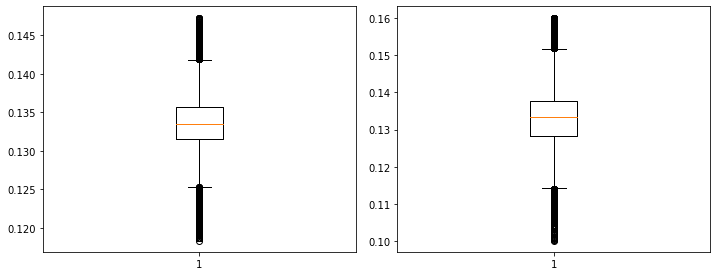






num_mentions_std histogram normal scale:


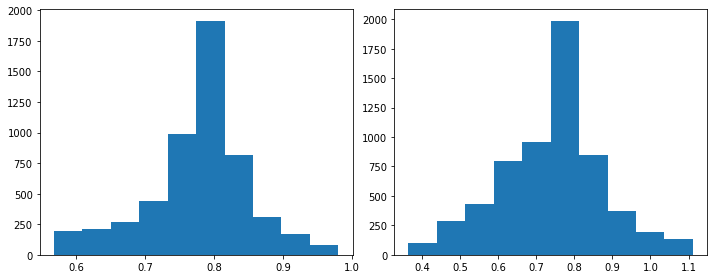


num_mentions_std histogram log scale:


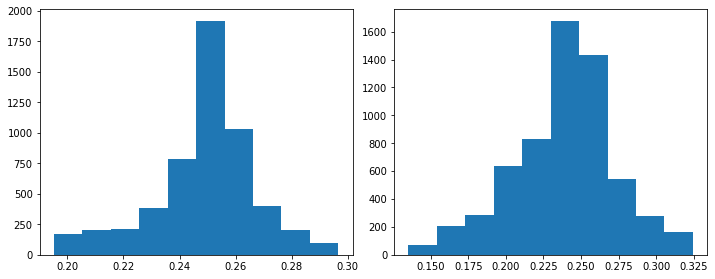


num_mentions_std boxplot normal scale:


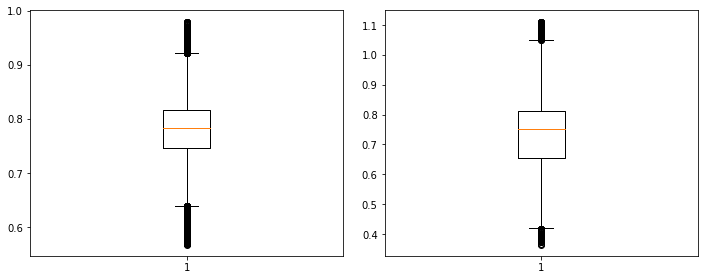


num_mentions_std boxplot log scale:


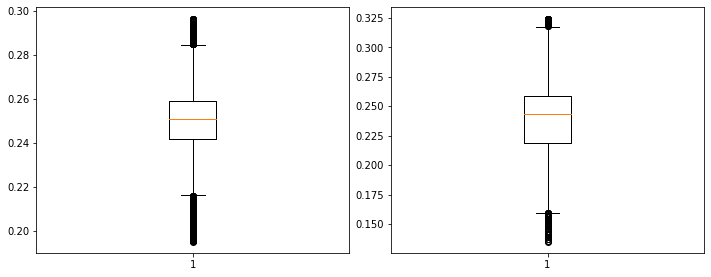






retweet_count_entropy histogram normal scale:


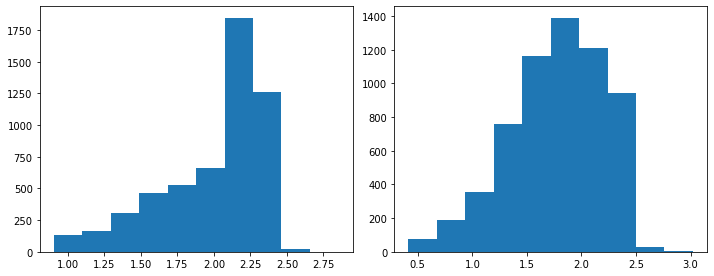


retweet_count_entropy histogram log scale:


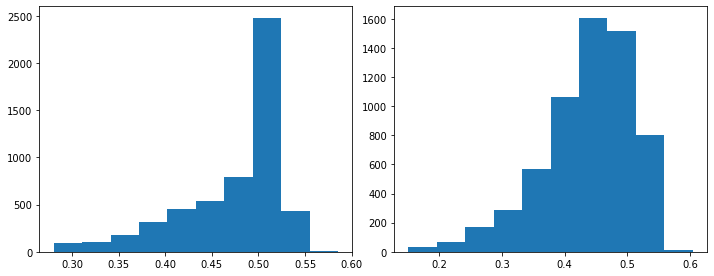


retweet_count_entropy boxplot normal scale:


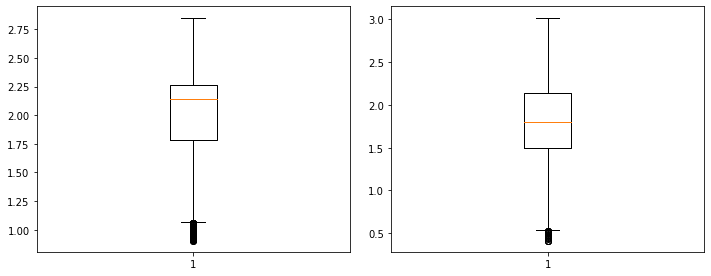


retweet_count_entropy boxplot log scale:


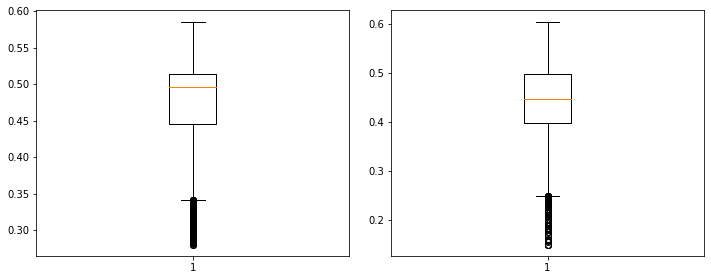






reply_count_entropy histogram normal scale:


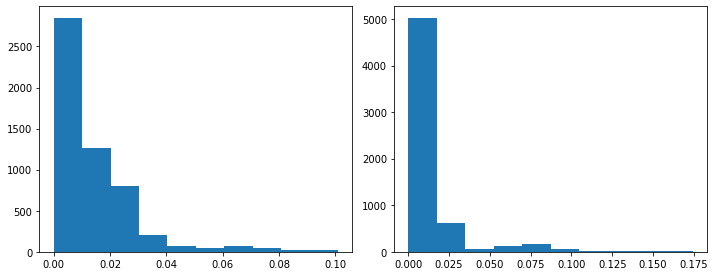


reply_count_entropy histogram log scale:


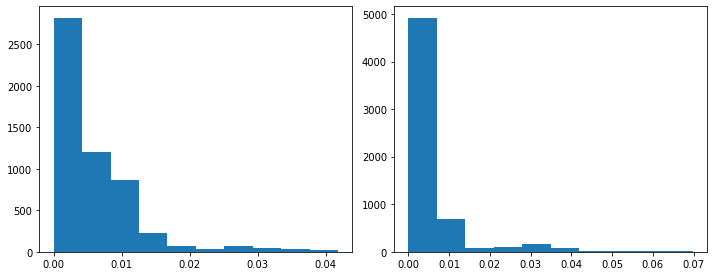


reply_count_entropy boxplot normal scale:


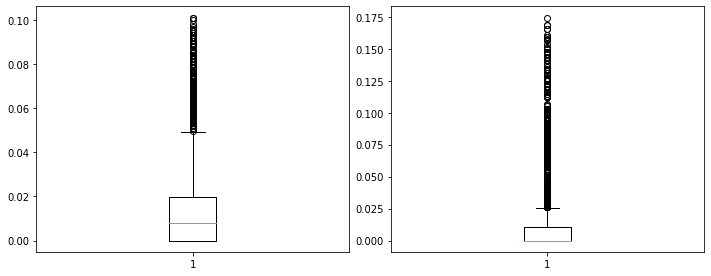


reply_count_entropy boxplot log scale:


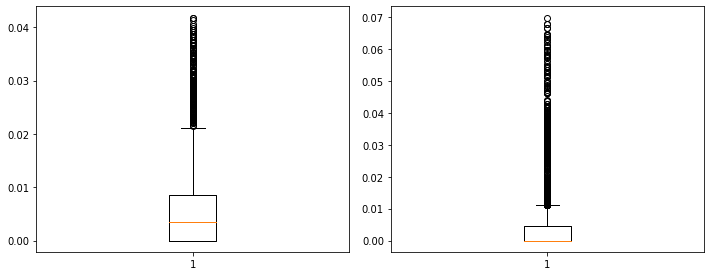






favorite_count_entropy histogram normal scale:


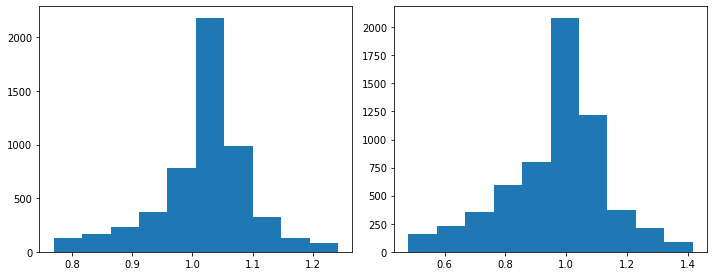


favorite_count_entropy histogram log scale:


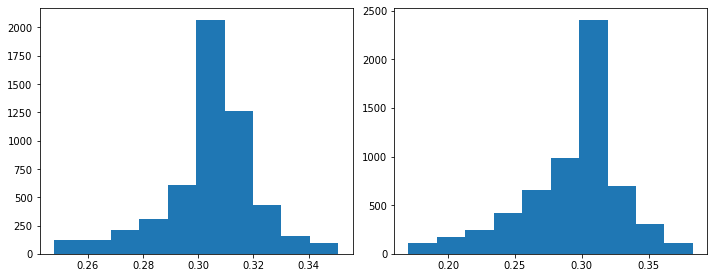


favorite_count_entropy boxplot normal scale:


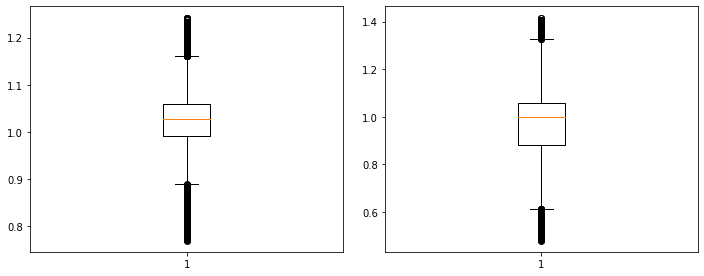


favorite_count_entropy boxplot log scale:


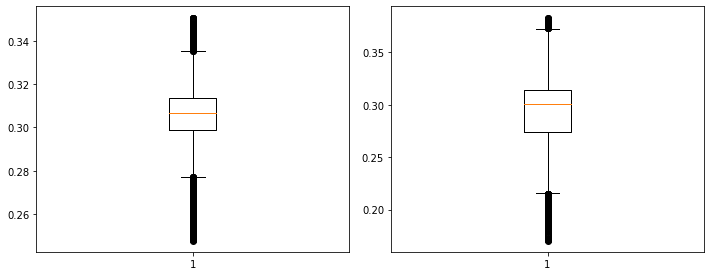






num_hashtags_entropy histogram normal scale:


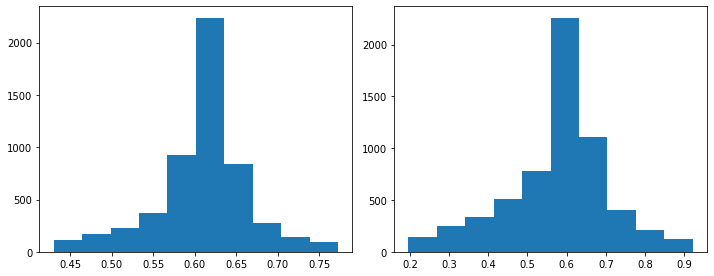


num_hashtags_entropy histogram log scale:


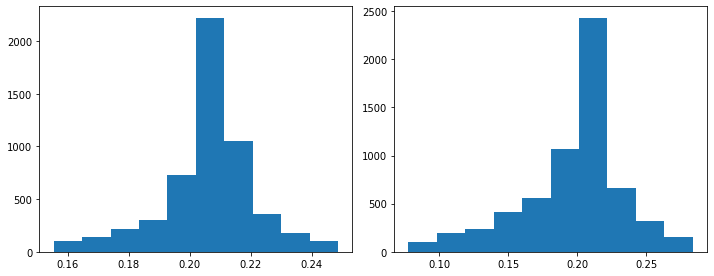


num_hashtags_entropy boxplot normal scale:


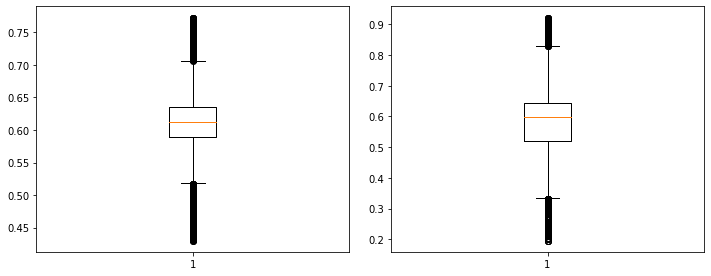


num_hashtags_entropy boxplot log scale:


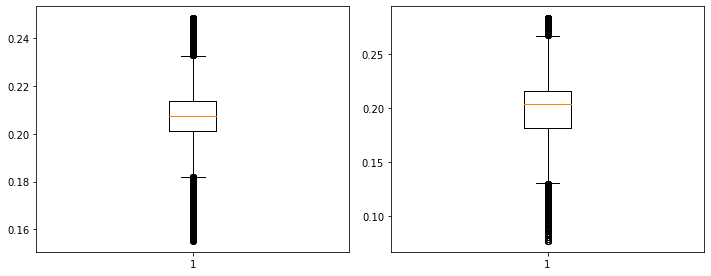






num_mentions_entropy histogram normal scale:


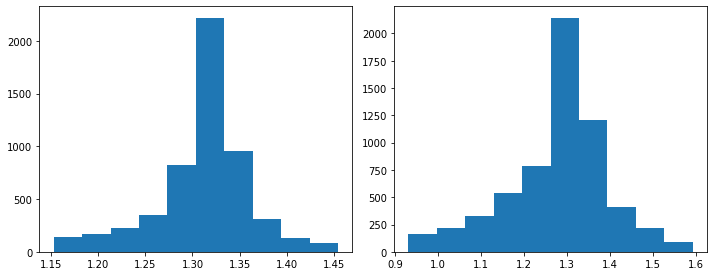


num_mentions_entropy histogram log scale:


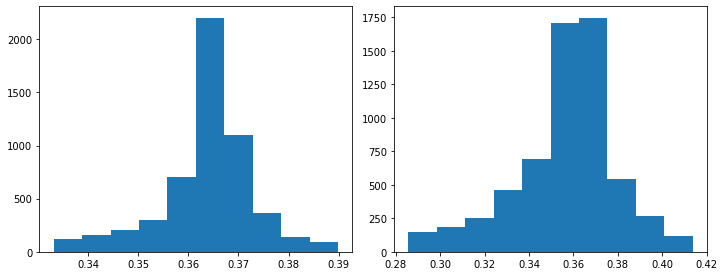


num_mentions_entropy boxplot normal scale:


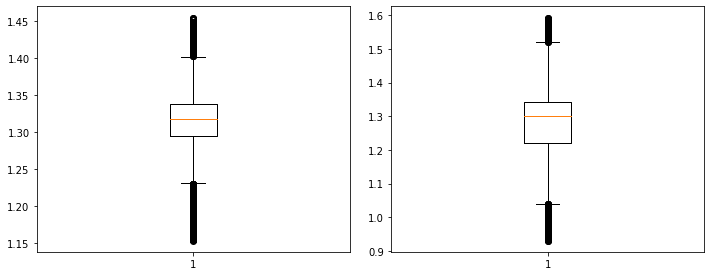


num_mentions_entropy boxplot log scale:


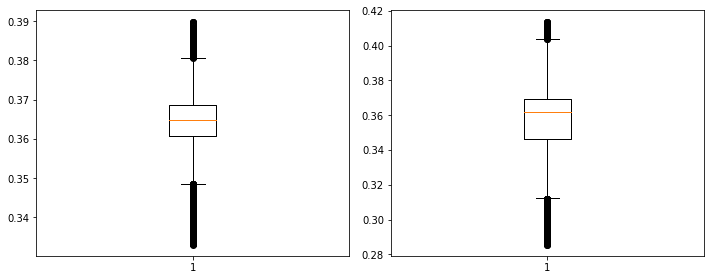






retweet_count_per_day histogram normal scale:


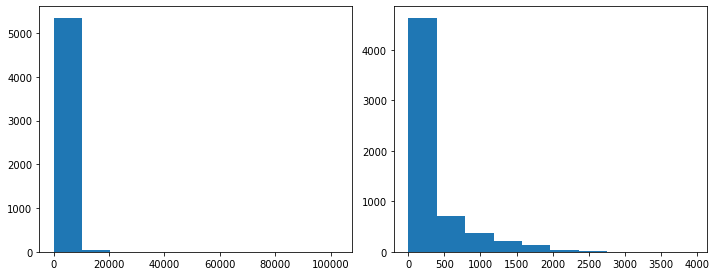


retweet_count_per_day histogram log scale:


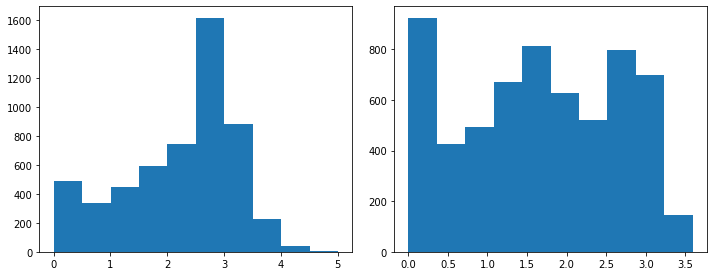


retweet_count_per_day boxplot normal scale:


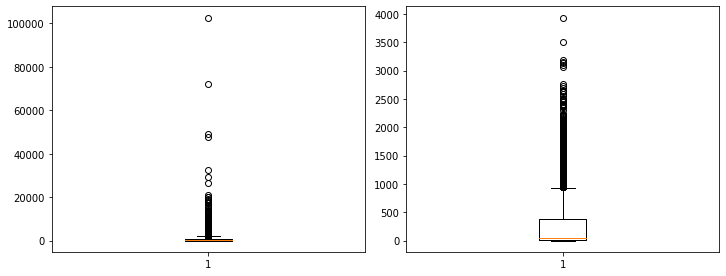


retweet_count_per_day boxplot log scale:


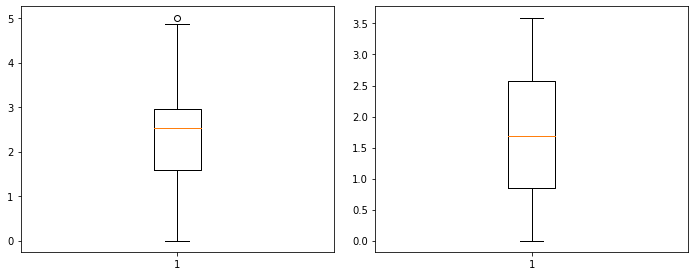






reply_count_per_day histogram normal scale:


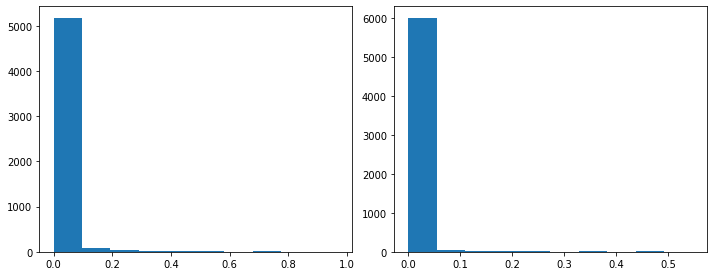


reply_count_per_day histogram log scale:


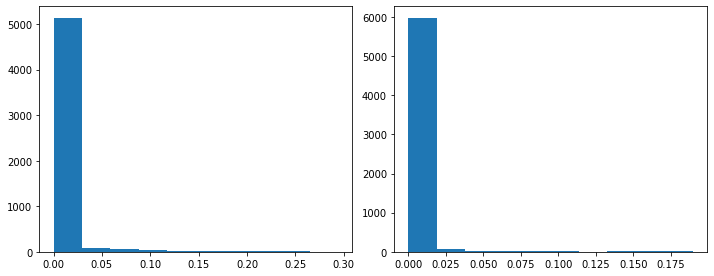


reply_count_per_day boxplot normal scale:


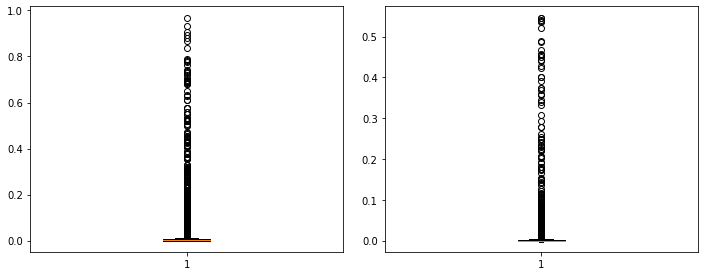


reply_count_per_day boxplot log scale:


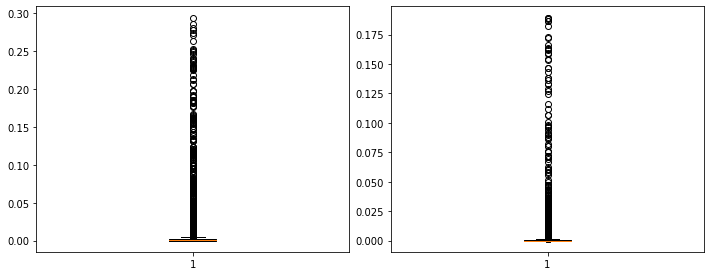






favorite_count_per_day histogram normal scale:


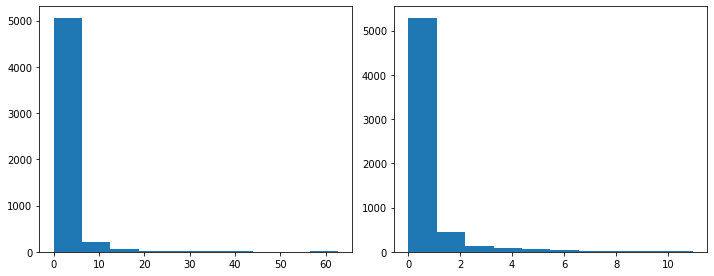


favorite_count_per_day histogram log scale:


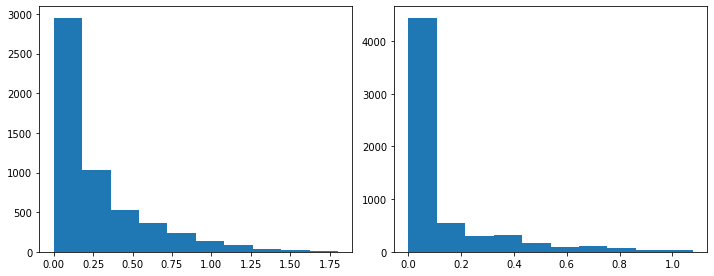


favorite_count_per_day boxplot normal scale:


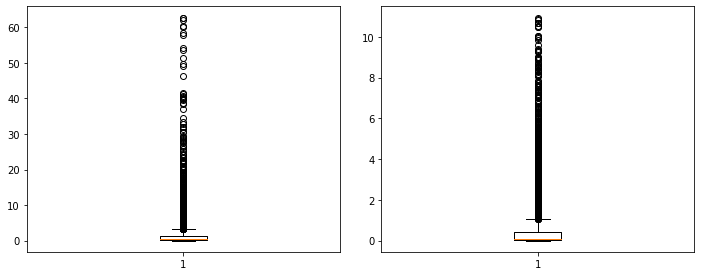


favorite_count_per_day boxplot log scale:


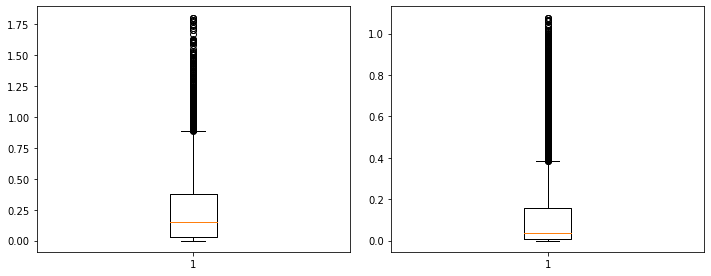






num_hashtags_per_day histogram normal scale:


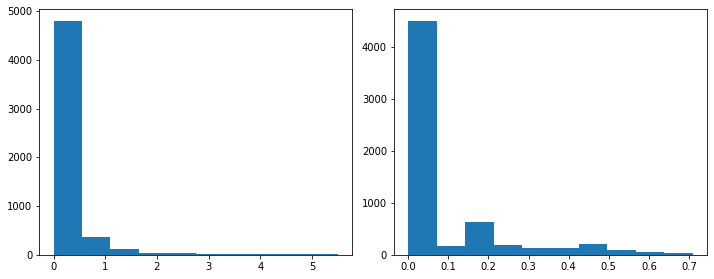


num_hashtags_per_day histogram log scale:


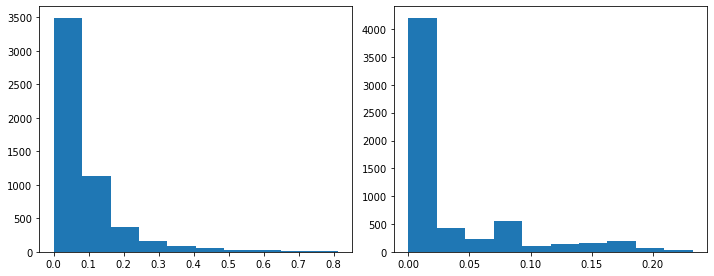


num_hashtags_per_day boxplot normal scale:


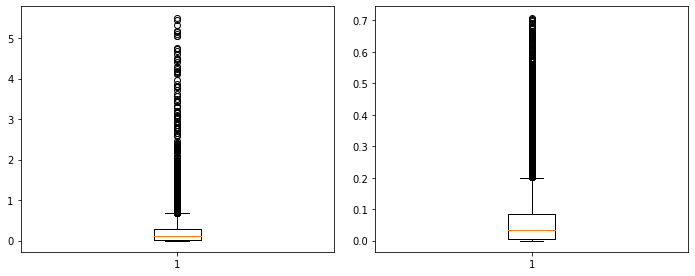


num_hashtags_per_day boxplot log scale:


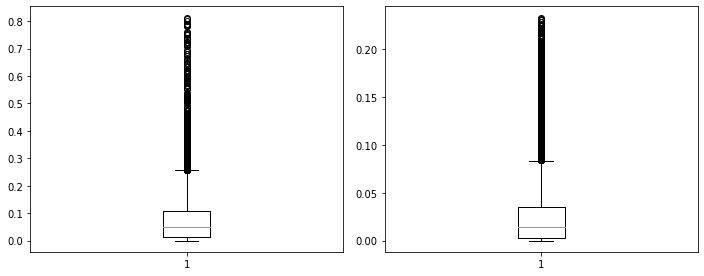






avg_len histogram normal scale:


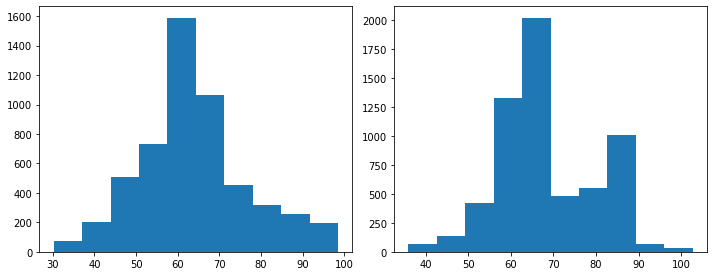


avg_len histogram log scale:


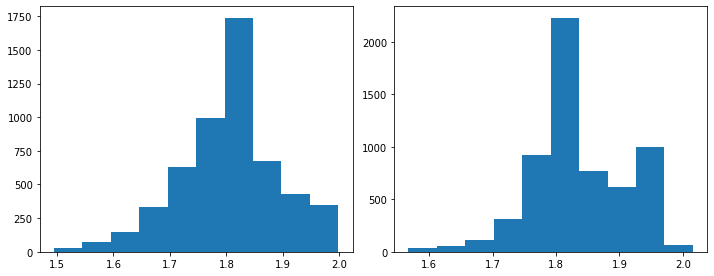


avg_len boxplot normal scale:


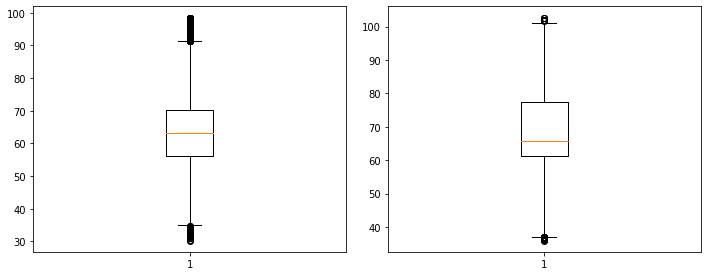


avg_len boxplot log scale:


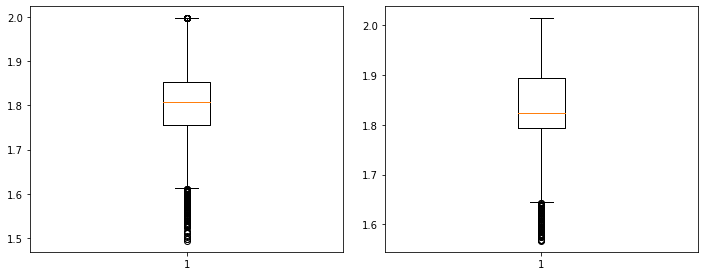






avg_spc_len histogram normal scale:


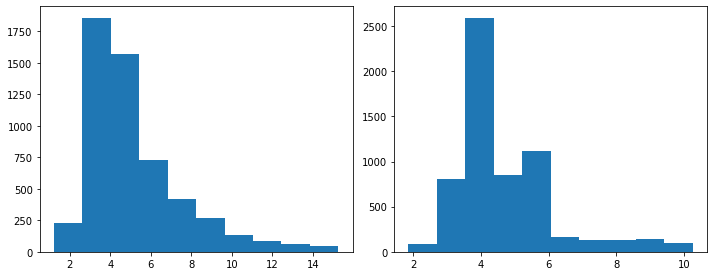


avg_spc_len histogram log scale:


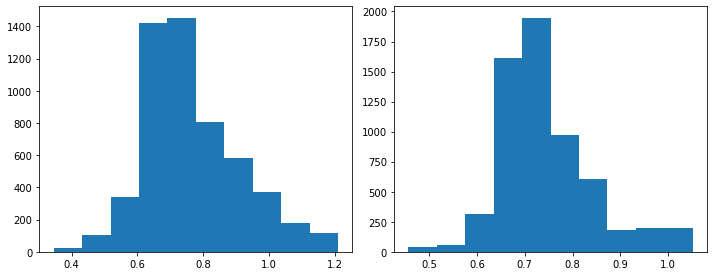


avg_spc_len boxplot normal scale:


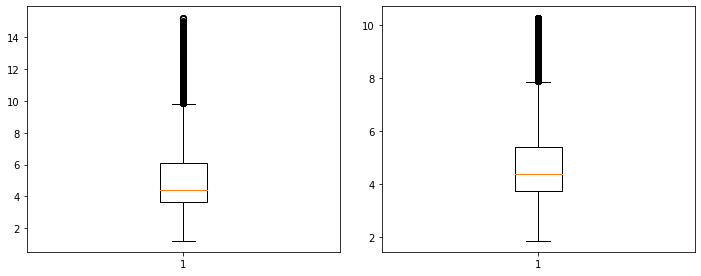


avg_spc_len boxplot log scale:


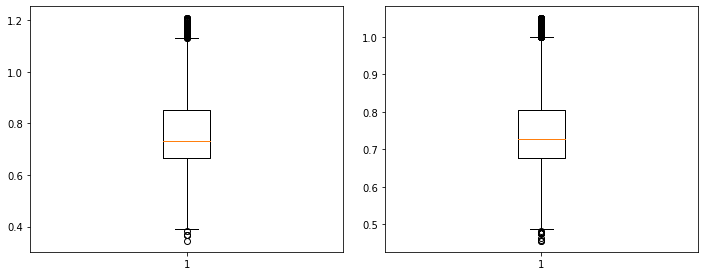

In [ ]:
cols = users.columns[5:]
for col in cols:
  visualize_distribution(col)
  print("\n\n\n")

In [ ]:

selected = users.columns.tolist()[5:]

In [ ]:
non_skewed_dists = [
  "avg_spc_len",
  "avg_len",
  "num_mentions_entropy",
  "num_hashtags_entropy",
  "favorite_count_entropy",
  "retweet_count_entropy",
  "num_mentions_std",
  "num_urls_std",
  "num_hashtags_std",
  "num_mentions_avg",
  "num_urls_avg"
]

In [ ]:
for col in selected:
  if col not in non_skewed_dists:
    print(col)
    users.loc[:, col] = users[col].apply(lambda x: np.log10(x+1))

statuses_count
reply_count_total
favorite_count_total
num_hashtags_total
retweet_count_avg
reply_count_avg
favorite_count_avg
num_hashtags_avg
retweet_count_std
reply_count_std
favorite_count_std
reply_count_entropy
retweet_count_per_day
reply_count_per_day
favorite_count_per_day
num_hashtags_per_day


# One hot encode the language (which is then not used)

In [ ]:
one_hot_langs = pd.get_dummies(users["lang"], prefix = "lang")
langs = one_hot_langs.columns.tolist()
one_hot_langs["id"] = users["id"]
# users = users.merge(one_hot_langs, on="id", how="inner")

# Train-test sets split

In [ ]:
users.drop(columns=['name', 'lang', 'created_at', "id"], axis=1, inplace=True)
# users = users[classification_cols+["bot"]]

In [ ]:
label = users.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(users, label, stratify =label, test_size=0.20)
train_set

,statuses_count,reply_count_total,favorite_count_total,num_hashtags_total,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,...,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_mentions_entropy,retweet_count_per_day,reply_count_per_day,favorite_count_per_day,num_hashtags_per_day,avg_len,avg_spc_len
5615,1.892095,0.30103,1.380211,0.954243,1.990946,0.005463,0.110973,0.041892,0.139241,0.493671,...,0.040579,0.867587,0.484232,1.269963,0.731471,0.000249,0.005687,0.001986,65.647059,3.810127
9753,1.322219,0.00000,1.204120,0.000000,1.848591,0.000000,0.218056,0.063485,0.147009,0.484092,...,0.000000,0.765364,0.598239,1.477747,0.468954,0.000000,0.007844,0.000000,46.565217,10.173913
3142,3.206016,0.30103,2.694605,2.274158,2.446899,0.000409,0.165885,0.070438,0.140301,0.524482,...,0.004675,1.051068,0.657308,1.390254,2.600404,0.000583,0.220915,0.097260,45.564030,2.149718
313,4.090575,0.00000,2.068186,1.643453,2.481620,0.000000,0.169488,0.070760,0.148148,0.481481,...,0.000000,1.207241,0.649875,1.298006,1.867828,0.000000,0.047261,0.018125,49.814815,3.135802
11102,1.591065,0.00000,1.556303,1.301030,1.829382,0.000000,0.154372,0.090508,0.134146,0.487526,...,0.000000,0.970495,0.612304,1.317073,1.136204,0.000000,0.033984,0.018778,68.268293,3.670732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11290,1.568202,0.00000,1.770852,0.301030,1.856830,0.000000,0.416825,0.063485,0.111111,0.416667,...,0.000000,1.034329,0.598239,1.190526,0.537831,0.000000,0.023525,0.000417,59.638889,8.472222
1296,3.388989,0.90309,3.068186,2.592177,2.309402,0.001364,0.183315,0.070113,0.146900,0.501348,...,0.013120,1.035029,0.665299,1.338508,2.597086,0.002647,0.305558,0.127303,50.266846,4.567385
66,3.310056,0.00000,0.477121,0.477121,2.537740,0.000000,0.051153,0.051153,0.250000,0.487526,...,0.000000,1.026191,0.612304,1.317073,0.798393,0.000000,0.000834,0.000834,53.750000,6.562500
6944,1.397940,0.00000,0.778151,0.845098,1.844839,0.000000,0.082187,0.096910,0.148148,0.487526,...,0.000000,0.785235,0.612304,1.176065,0.413525,0.000000,0.002083,0.002498,79.333333,10.875000


In [ ]:
print(train_set.shape, train_label.shape)
print(test_set.shape, test_label.shape)

(9206, 27) (9206,)
(2302, 27) (2302,)


In [ ]:
langs

['lang_ar',
 'lang_da',
 'lang_de',
 'lang_el',
 'lang_en',
 'lang_es',
 'lang_fil',
 'lang_fr',
 'lang_id',
 'lang_it',
 'lang_ja',
 'lang_ko',
 'lang_nl',
 'lang_pl',
 'lang_pt',
 'lang_ru',
 'lang_sv',
 'lang_tr',
 'lang_zh']

# Standardize the data

In [ ]:
columns = train_set.columns.tolist()
non_lang_cols = list(filter(lambda x: x not in langs, columns)) 

In [ ]:
unnorm_train_set = train_set.copy()
unnorm_test_set = test_set.copy()
norm_train_set = train_set.copy()
norm_test_set = test_set.copy()

method = "standard"

if method == "minmax":
  scaler = MinMaxScaler()
elif method == "standard":
  scaler = StandardScaler()

norm_train_set.loc[:, non_lang_cols] = scaler.fit_transform(norm_train_set.loc[:, non_lang_cols])
norm_test_set.loc[:, non_lang_cols] = scaler.transform(norm_test_set.loc[:, non_lang_cols])

# SVM

In [ ]:
train_set = norm_train_set.copy()
test_set = norm_test_set.copy()

In [ ]:
# defining parameter ranges
params = [
  {
      "kernel": ["linear"],
      "C": [0.001, 0.01, 1, 10],
  },
  {
      "kernel": ["sigmoid"],
      "C": [10**e for e in range(-4, 3)]
  },
  {
      "kernel": ["rbf"],
      "C": [1, 10, 100, 1000],
      "gamma": [10**e for e in range(-5, 1)]
  },
  {
      "kernel": ["poly"],
      "C": [1, 10, 100],
      "degree": [1,2,3,5,7,10,15,20]
  }
]


grid = GridSearchCV(SVC(random_state=42), params, verbose=4, cv=5)
  
# fitting the model for grid search
grid.fit(train_set, train_label)

Fitting 5 folds for each of 59 candidates, totalling 295 fits
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.825 total time=   2.9s
[CV 2/5] END ............C=0.001, kernel=linear;, score=0.837 total time=   2.3s
[CV 3/5] END ............C=0.001, kernel=linear;, score=0.826 total time=   2.4s
[CV 4/5] END ............C=0.001, kernel=linear;, score=0.812 total time=   2.2s
[CV 5/5] END ............C=0.001, kernel=linear;, score=0.821 total time=   2.2s
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.834 total time=   1.7s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.851 total time=   1.8s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.837 total time=   1.7s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.826 total time=   1.7s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.823 total time=   1.6s
[CV 1/5] END ................C=1, kernel=linear;, score=0.834 total time=   4.4s
[CV 2/5] END ................C=1, kernel=linear

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid=[{'C': [0.001, 0.01, 1, 10], 'kernel': ['linear']},
                         {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['sigmoid']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100],
                          'degree': [1, 2, 3, 5, 7, 10, 15, 20],
                          'kernel': ['poly']}],
             verbose=4)

In [ ]:
print(grid.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
model = grid.best_estimator_
model.fit(train_set, train_label)

SVC(C=100, gamma=0.01, random_state=42)

In [ ]:
train_pred = model.predict(train_set)
test_pred = model.predict(test_set)

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9477514664349337
Accuracy test set  0.9257167680278019
Precision train set  0.951863990167964
Precision test set  0.9214743589743589
Recall train set  0.9497240956468425
Recall test set  0.9403107113654947
F1 score train set  0.9507928388746802
F1 score test set  0.9307972480777014
Support train set  [4313 4893]
Support test set  [1079 1223]


In [ ]:
print_report(test_label, test_pred)

              precision    recall  f1-score   support

        Real       0.93      0.91      0.92      1079
         Bot       0.92      0.94      0.93      1223

    accuracy                           0.93      2302
   macro avg       0.93      0.92      0.93      2302
weighted avg       0.93      0.93      0.93      2302



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


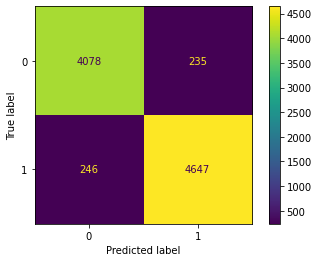

In [ ]:
print_confusion_matrix(model, train_set, train_label)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


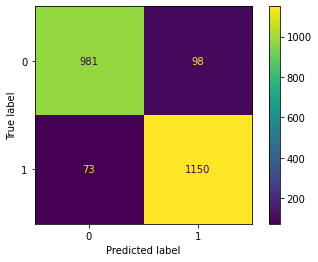

In [ ]:
print_confusion_matrix(model, test_set, test_label)

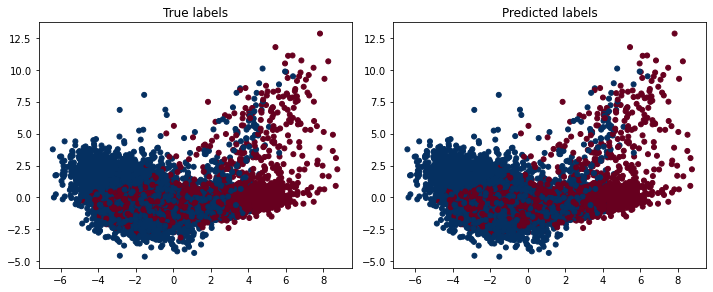

In [ ]:
print_scatter(train_set, train_label, train_pred)

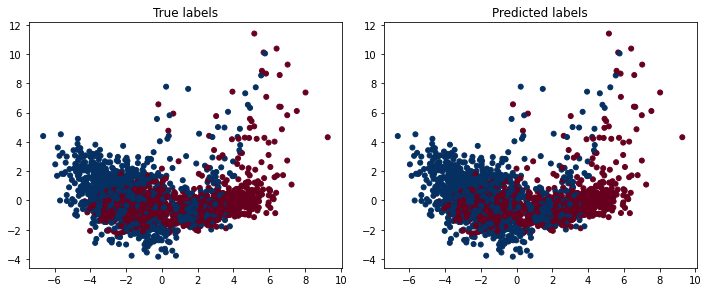

In [ ]:
print_scatter(test_set, test_label, test_pred)

In [ ]:
filename = 'svm.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
!cp svm.sav /content/drive/Shareddrives/DM_Project/models

# Knn

In [ ]:
knn = KNeighborsClassifier()
# k_range = list(range(1, 31))
k_range = list(range(1,51))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=4)
  
# fitting the model for grid search
grid.fit(train_set, train_label)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.857 total time=   0.4s
[CV 2/5] END .....................n_neighbors=1;, score=0.860 total time=   0.3s
[CV 3/5] END .....................n_neighbors=1;, score=0.862 total time=   0.2s
[CV 4/5] END .....................n_neighbors=1;, score=0.867 total time=   0.3s
[CV 5/5] END .....................n_neighbors=1;, score=0.850 total time=   0.3s
[CV 1/5] END .....................n_neighbors=2;, score=0.839 total time=   0.3s
[CV 2/5] END .....................n_neighbors=2;, score=0.835 total time=   0.3s
[CV 3/5] END .....................n_neighbors=2;, score=0.846 total time=   0.3s
[CV 4/5] END .....................n_neighbors=2;, score=0.844 total time=   0.3s
[CV 5/5] END .....................n_neighbors=2;, score=0.832 total time=   0.3s
[CV 1/5] END .....................n_neighbors=3;, score=0.874 total time=   0.3s
[CV 2/5] END .....................n_neighbors=3

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy', verbose=4)

In [ ]:
print(grid.best_params_)

{'n_neighbors': 17}


In [ ]:
model = grid.best_estimator_
model.fit(train_set, train_label)

KNeighborsClassifier(n_neighbors=17)

In [ ]:
train_pred = model.predict(train_set)
test_pred = model.predict(test_set)

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9070171627199652
Accuracy test set  0.894874022589053
Precision train set  0.9037807561512302
Precision test set  0.8895949166004765
Recall train set  0.9233599019006744
Recall test set  0.9157808667211774
F1 score train set  0.9134654266073595
F1 score test set  0.902497985495568
Support train set  [4313 4893]
Support test set  [1079 1223]


In [ ]:
print_report(test_label, test_pred)

              precision    recall  f1-score   support

        Real       0.90      0.87      0.89      1079
         Bot       0.89      0.92      0.90      1223

    accuracy                           0.89      2302
   macro avg       0.90      0.89      0.89      2302
weighted avg       0.90      0.89      0.89      2302



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


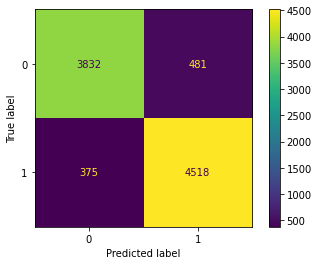

In [ ]:
print_confusion_matrix(model, train_set, train_label)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


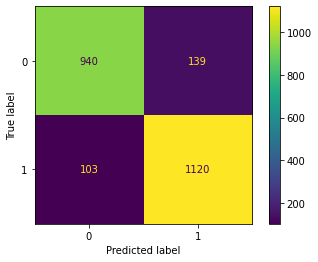

In [ ]:
print_confusion_matrix(model, test_set, test_label)

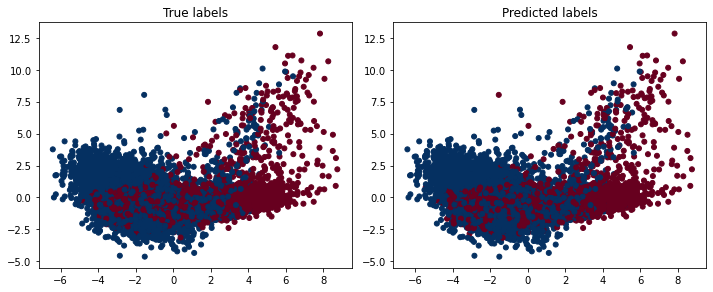

In [ ]:
print_scatter(train_set, train_label, train_pred)

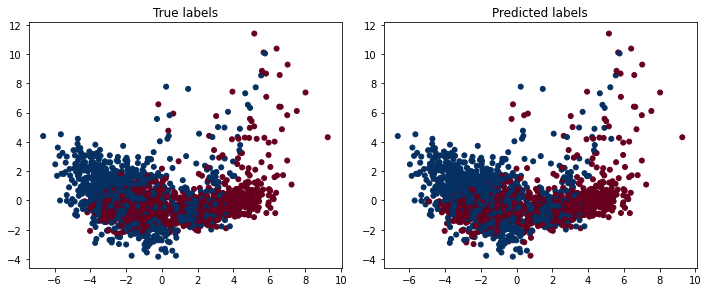

In [ ]:
print_scatter(test_set, test_label, test_pred)

# Naive bayes

In [ ]:
train_set = norm_train_set.copy()
test_set = norm_test_set.copy()

In [ ]:
model = GaussianNB()
model.fit(train_set, train_label)

GaussianNB()

In [ ]:
train_pred = model.predict(train_set)
test_pred = model.predict(test_set)

In [ ]:
print(train_label.shape, train_pred.shape)
print(test_label.shape, test_pred.shape)

(9206,) (9206,)
(2302,) (2302,)


In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.7041060178144688
Accuracy test set  0.6985230234578628
Precision train set  0.7118577847235789
Precision test set  0.7110933758978452
Recall train set  0.744737379930513
Recall test set  0.7285363859362224
F1 score train set  0.7279264882141432
F1 score test set  0.7197092084006462
Support train set  [4313 4893]
Support test set  [1079 1223]


In [ ]:
print_report(test_label, test_pred)

              precision    recall  f1-score   support

        Real       0.68      0.66      0.67      1079
         Bot       0.71      0.73      0.72      1223

    accuracy                           0.70      2302
   macro avg       0.70      0.70      0.70      2302
weighted avg       0.70      0.70      0.70      2302



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


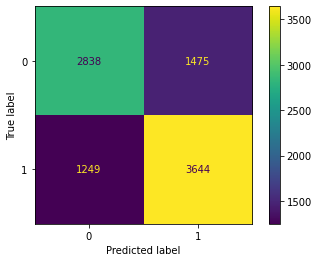

In [ ]:
print_confusion_matrix(model, train_set, train_label)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


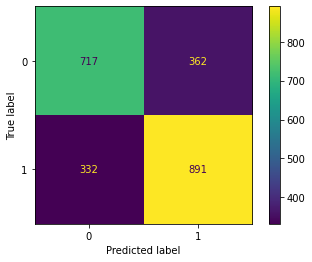

In [ ]:
print_confusion_matrix(model, test_set, test_label)

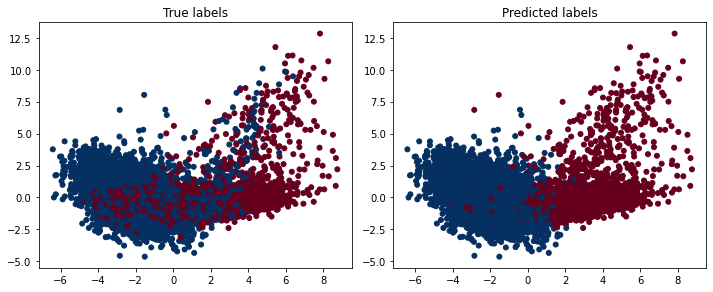

In [ ]:
print_scatter(train_set, train_label, train_pred)

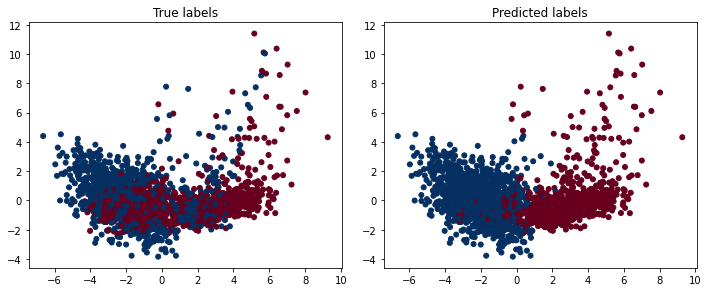

In [ ]:
print_scatter(test_set, test_label, test_pred)

# Decision Tree

In [ ]:
train_set = norm_train_set.copy()
test_set = norm_test_set.copy()

In [ ]:
#define a decision tree and fit it

max_depth = [int(x) for x in np.linspace(20, 60, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2, 20, num = 1)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(2, 20, num = 1)]

param_dict = {
    "criterion" : ["gini","entropy"],
    "max_depth" : max_depth,
    "max_features": ["auto", "sqrt", None],
    "min_samples_split":min_samples_split,
    "min_samples_leaf":min_samples_leaf
}

decision_tree = tree.DecisionTreeClassifier()

grid = GridSearchCV(decision_tree, param_grid=param_dict, cv = 5, verbose = 4, n_jobs=-1)

grid.fit(train_set, train_label)

Fitting 5 folds for each of 66 candidates, totalling 330 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 24, 28, 33, 37, 42, 46, 51, 55, 60,
                                       None],
                         'max_features': ['auto', 'sqrt', None],
                         'min_samples_leaf': [2], 'min_samples_split': [2]},
             verbose=4)

In [ ]:
print(grid.best_params_)

{'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
dt = tree.DecisionTreeClassifier(criterion=grid.best_params_["criterion"], splitter='best', 
                                  max_depth=grid.best_params_["max_depth"], 
                                  max_features=grid.best_params_["max_features"], 
                                  min_samples_split=grid.best_params_["min_samples_split"], 
                                  min_samples_leaf=grid.best_params_["min_samples_leaf"])
dt = dt.fit(train_set, train_label)

In [ ]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['Real', 'Bot'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_pred = dt.predict(train_set)
test_pred = dt.predict(test_set)

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9567673256571801
Accuracy test set  0.9331016507384883
Precision train set  0.9368318756073858
Precision test set  0.9064638783269962
Recall train set  0.985080727569998
Recall test set  0.9746524938675388
F1 score train set  0.9603506674636381
F1 score test set  0.9393223010244286
Support train set  [4313 4893]
Support test set  [1079 1223]


In [ ]:
print_report(test_label, test_pred)

              precision    recall  f1-score   support

        Real       0.97      0.89      0.93      1079
         Bot       0.91      0.97      0.94      1223

    accuracy                           0.93      2302
   macro avg       0.94      0.93      0.93      2302
weighted avg       0.94      0.93      0.93      2302



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


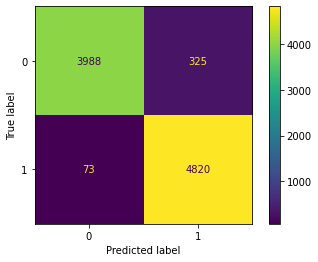

In [ ]:
print_confusion_matrix(dt, train_set, train_label)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


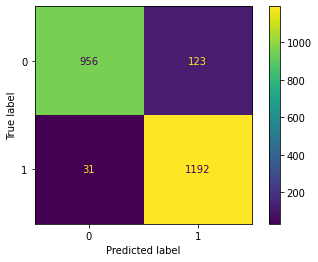

In [ ]:
print_confusion_matrix(dt, test_set, test_label)

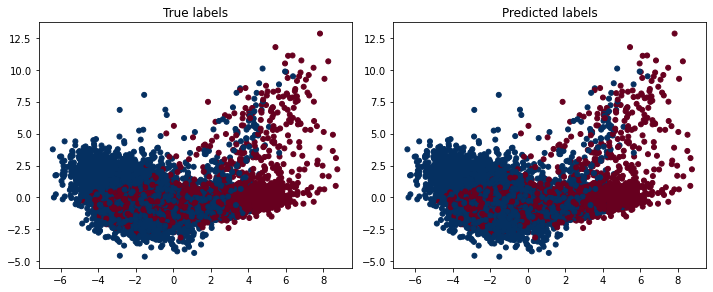

In [ ]:
print_scatter(train_set, train_label, train_pred)

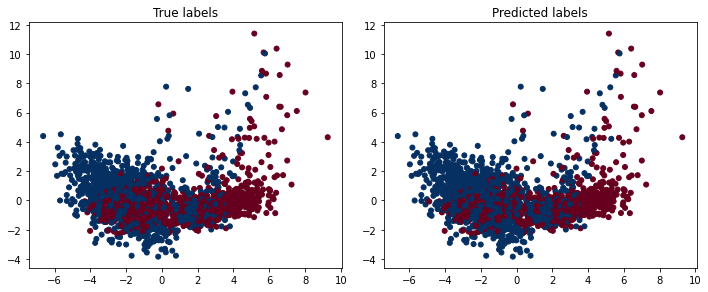

In [ ]:
print_scatter(test_set, test_label, test_pred)

# Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 50, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [20, 23, 26, 30, 33, 36, 40, 43, 46, 50, None],
 'max_features': ['auto', 'sqrt', None],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [2, 5],
 'n_estimators': [10, 20, 30, 40, 50]}


In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_set, train_label)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 23, 26, 30, 33, 36,
                                                      40, 43, 46, 50, None],
                                        'max_features': ['auto', 'sqrt', None],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 20, 30, 40, 50]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 36,
 'bootstrap': False}

In [ ]:
best_rf = RandomForestClassifier(n_estimators = rf_random.best_params_['n_estimators'], 
                             criterion='gini',
                             max_features=rf_random.best_params_['max_features'],
                             max_depth=rf_random.best_params_['max_depth'], 
                             min_samples_split=rf_random.best_params_['min_samples_split'],
                             min_samples_leaf=rf_random.best_params_['min_samples_leaf'],
                             bootstrap=rf_random.best_params_['bootstrap']) 
best_rf = rf.fit(train_set, train_label)

In [ ]:
train_pred = rf.predict(train_set)
test_pred = rf.predict(test_set)

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  1.0
Accuracy test set  0.9582971329278888
Precision train set  1.0
Precision test set  0.9419607843137255
Recall train set  1.0
Recall test set  0.982011447260834
F1 score train set  1.0
F1 score test set  0.9615692554043235
Support train set  [4313 4893]
Support test set  [1079 1223]


In [ ]:
print_report(test_label, test_pred)

              precision    recall  f1-score   support

        Real       0.98      0.93      0.95      1079
         Bot       0.94      0.98      0.96      1223

    accuracy                           0.96      2302
   macro avg       0.96      0.96      0.96      2302
weighted avg       0.96      0.96      0.96      2302



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


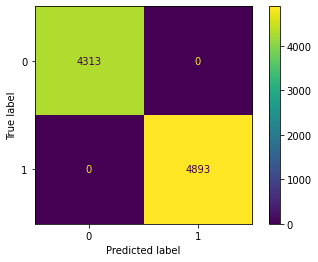

In [ ]:
print_confusion_matrix(rf, train_set, train_label)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


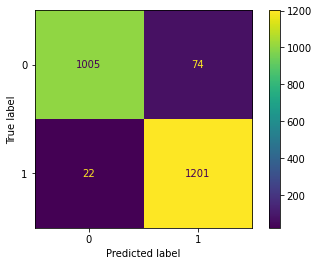

In [ ]:
print_confusion_matrix(rf, test_set, test_label)

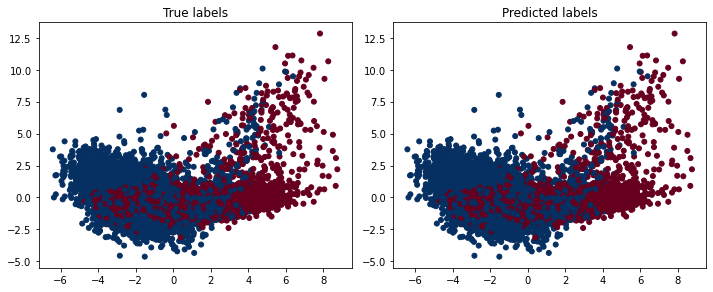

In [ ]:
print_scatter(train_set, train_label, train_pred)

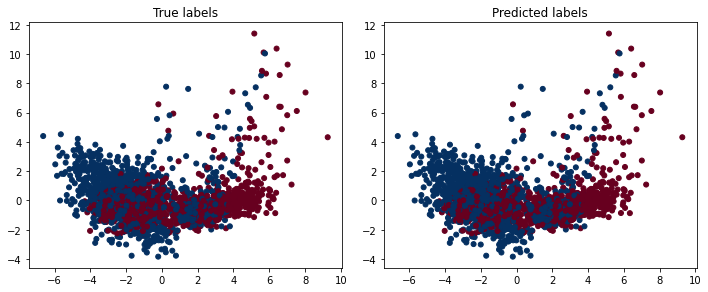

In [ ]:
print_scatter(test_set, test_label, test_pred)

# AdaBoost

In [ ]:
model = AdaBoostClassifier(random_state=42)

parameters = {
              'n_estimators':[10, 20, 50, 100, 200, 300, 500, 750, 1000],
              'learning_rate':[0.1, 0.01, 1, 10]
              }

grid = GridSearchCV(model, parameters, verbose=3, cv = 5, scoring='accuracy', n_jobs=-1)

grid.fit(train_set, train_label)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 1, 10],
                         'n_estimators': [10, 20, 50, 100, 200, 300, 500, 750,
                                          1000]},
             scoring='accuracy', verbose=3)

In [ ]:
grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

In [ ]:
model = grid.best_estimator_
model.fit(train_set, train_label)

AdaBoostClassifier(learning_rate=0.1, n_estimators=1000, random_state=42)

In [ ]:
train_pred = model.predict(train_set)
test_pred = model.predict(test_set)

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.96980230284597
Accuracy test set  0.9652476107732406
Precision train set  0.9651279983874219
Precision test set  0.9597747385358005
Recall train set  0.9785407725321889
Recall test set  0.9754701553556827
F1 score train set  0.9717881063527501
F1 score test set  0.9675587996755881
Support train set  [4313 4893]
Support test set  [1079 1223]


In [ ]:
print_report(test_label, test_pred)

              precision    recall  f1-score   support

        Real       0.97      0.95      0.96      1079
         Bot       0.96      0.98      0.97      1223

    accuracy                           0.97      2302
   macro avg       0.97      0.96      0.97      2302
weighted avg       0.97      0.97      0.97      2302



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


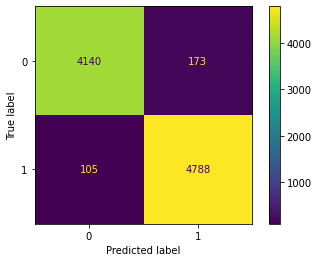

In [ ]:
print_confusion_matrix(model, train_set, train_label)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


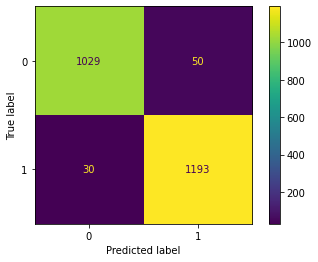

In [ ]:
print_confusion_matrix(model, test_set, test_label)

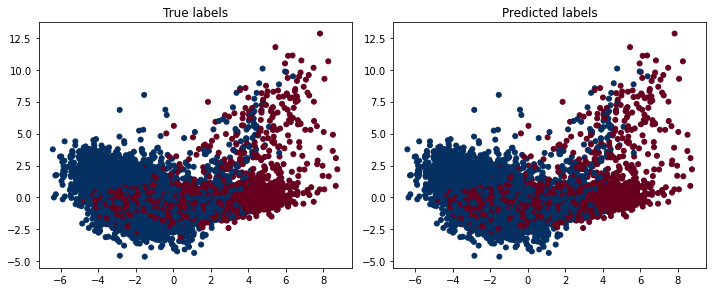

In [ ]:
print_scatter(train_set, train_label, train_pred)

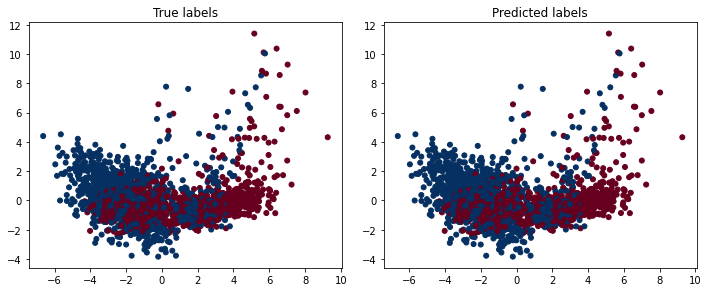

In [ ]:
print_scatter(test_set, test_label, test_pred)

#Neural Network


In [ ]:
train_set = norm_train_set.copy()
test_set = norm_test_set.copy()

In [ ]:
def F1_score(precision, recall):
    return (2 * precision * recall)/ (precision + recall)

n_units = [8, 16]
def init_model(n_units):
  sequential_model = [
      tf.keras.layers.Dense(n_units[0], activation='relu',
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros',
                            kernel_regularizer=tf.keras.regularizers.L2(0.01),
                            bias_regularizer=tf.keras.regularizers.L2(0.01)
                            ),
      tf.keras.layers.Dense(n_units[1], activation='relu',
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros',
                            kernel_regularizer=tf.keras.regularizers.L2(0.01),
                            bias_regularizer=tf.keras.regularizers.L2(0.01)
                            ),
      tf.keras.layers.Dense(1, activation='sigmoid',
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros',
                            kernel_regularizer=tf.keras.regularizers.L2(0.01),
                            bias_regularizer=tf.keras.regularizers.L2(0.01)
                            )
  ]
  return sequential_model

K = 5

_metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
]

_loss = tf.keras.losses.binary_crossentropy
_lr = [0.00005, 0.0001, 0.0002, 0.001, 0.002]

configs = []
for k in range(K):
  configs.append({
      "loss":_loss,
      "optimizer": tf.keras.optimizers.Adam(learning_rate=_lr[k]),
      "metrics": _metrics
  })

In [ ]:
tf.random.set_seed(42)

epochs = 100
best_loss = 10000
best_hist = None
delimiter = "#"*30
batch_size = 4

kf = KFold(n_splits=K)
kf.get_n_splits(train_set)
i = 0 
for train_index, test_index in kf.split(train_set):
  print("{} Model_{} {}".format(delimiter, i, delimiter))
  model = tf.keras.Sequential(init_model(n_units))
  model.compile(**configs[i])
  log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  i+=1
  # print("train_index:{}".format(train_index))
  X_train = train_set.iloc[train_index]
  Y_train = train_label.iloc[train_index]
  validation = train_set.iloc[test_index]
  validation_label = train_label.iloc[test_index]
  history = model.fit(X_train, Y_train,
                      validation_data=(validation, validation_label),
                      epochs=epochs, 
                      batch_size=batch_size,
                      verbose=2,
                      callbacks=[tensorboard_callback]
                      )
  f1_train =  F1_score(history.history["precision"][-1],history.history["recall"][-1])
  f1_val =  F1_score(history.history["val_precision"][-1],history.history["val_recall"][-1])
  print("train F1-score: ", f1_train)
  print("validation F1-score: ", f1_val)

  if history.history["val_loss"][-1] < best_loss:
    best_loss = history.history["val_loss"][-1]
    best_hist = history.history
    model_unit_str = '_'.join(str(x) for x in n_units)
    model.save("./best_NN_model"+model_unit_str)

############################## Model_0 ##############################
Epoch 1/100
1841/1841 - 6s - loss: 1.0141 - accuracy: 0.4508 - precision: 0.4837 - recall: 0.5246 - val_loss: 0.8954 - val_accuracy: 0.5440 - val_precision: 0.5573 - val_recall: 0.7244 - 6s/epoch - 3ms/step
Epoch 2/100
1841/1841 - 3s - loss: 0.8406 - accuracy: 0.6240 - precision: 0.6044 - recall: 0.8428 - val_loss: 0.7911 - val_accuracy: 0.6726 - val_precision: 0.6416 - val_recall: 0.8815 - 3s/epoch - 2ms/step
Epoch 3/100
1841/1841 - 4s - loss: 0.7634 - accuracy: 0.7227 - precision: 0.6779 - recall: 0.9091 - val_loss: 0.7284 - val_accuracy: 0.7481 - val_precision: 0.7077 - val_recall: 0.9027 - 4s/epoch - 2ms/step
Epoch 4/100
1841/1841 - 4s - loss: 0.7067 - accuracy: 0.7672 - precision: 0.7181 - recall: 0.9240 - val_loss: 0.6746 - val_accuracy: 0.7747 - val_precision: 0.7333 - val_recall: 0.9108 - 4s/epoch - 2ms/step
Epoch 5/100
1841/1841 - 3s - loss: 0.6556 - accuracy: 0.7873 - precision: 0.7374 - recall: 0.9304 - va

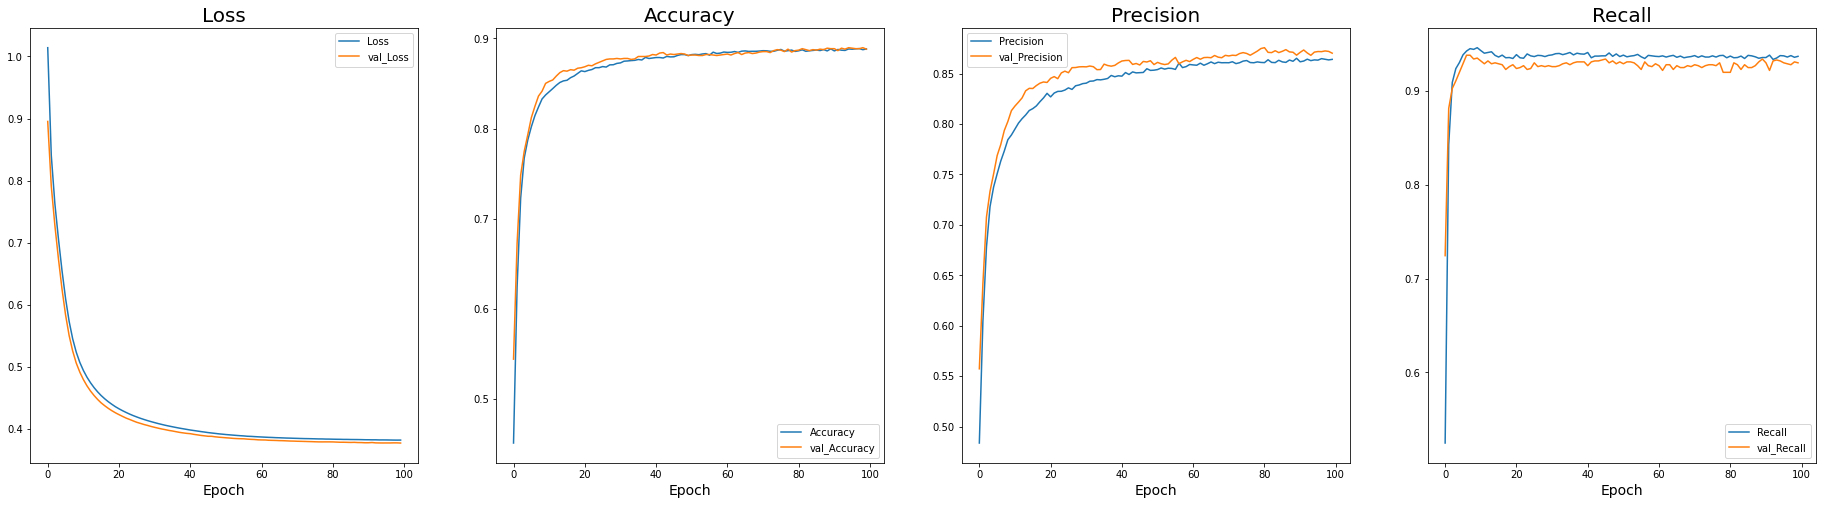

In [ ]:
def plot_history(history):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(32, 8))
  ax1.plot(
      np.arange(len(history['loss'])), 
      history['loss'], label='Loss'
  )
  ax2.plot(
      np.arange(len(history['accuracy'])), 
      history['accuracy'], label='Accuracy'
  )
  ax3.plot(
      np.arange(len(history['precision'])), 
      history['precision'], label='Precision'
  )
  ax4.plot(
      np.arange(len(history['recall'])), 
      history['recall'], label='Recall'
  )
  ax1.plot(
      np.arange(len(history['loss'])), 
      history['val_loss'], label='val_Loss'
  )
  ax2.plot(
      np.arange(len(history['accuracy'])), 
      history['val_accuracy'], label='val_Accuracy'
  )
  ax3.plot(
      np.arange(len(history['precision'])), 
      history['val_precision'], label='val_Precision'
  )
  ax4.plot(
      np.arange(len(history['recall'])), 
      history['val_recall'], label='val_Recall'
  )
  ax1.set_title('Loss', size=20)
  ax1.set_xlabel('Epoch', size=14)
  ax1.legend();
  ax2.set_title('Accuracy', size=20)
  ax2.set_xlabel('Epoch', size=14)
  ax2.legend();
  ax3.set_title('Precision', size=20)
  ax3.set_xlabel('Epoch', size=14)
  ax3.legend();
  ax4.set_title('Recall', size=20)
  ax4.set_xlabel('Epoch', size=14)
  ax4.legend();

plot_history(best_hist)

In [ ]:
model = tf.keras.models.load_model('./best_NN_model8_16')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 224       
                                                                 
 dense_7 (Dense)             (None, 16)                144       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


wrapper for sklearn

In [ ]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = [1 if x >= 0.5 else 0 for x in y_prob]
    return y_pred

classifier = estimator(model, "tf_model")

In [ ]:
train_pred = model.predict(train_set)
test_pred = model.predict(test_set)

72/72 [==============================] - 0s 1ms/step


In [ ]:
train_pred = pd.Series(train_pred.reshape(-1))
test_pred = pd.Series(test_pred.reshape(-1))

In [ ]:
train_pred = train_pred.apply(lambda x: 1 if x >=0.5 else 0)
test_pred = test_pred.apply(lambda x: 1 if x >= 0.5 else 0 )

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8882250706061264
Accuracy test set  0.8783666377063423
Precision train set  0.8646659116647791
Precision test set  0.8542449286250939
Recall train set  0.9362354383813611
Recall test set  0.9296811120196239
F1 score train set  0.8990285546070063
F1 score test set  0.8903680501174628
Support train set  [4313 4893]
Support test set  [1079 1223]


In [ ]:
print_report(test_label, test_pred)

              precision    recall  f1-score   support

        Real       0.91      0.82      0.86      1079
         Bot       0.85      0.93      0.89      1223

    accuracy                           0.88      2302
   macro avg       0.88      0.87      0.88      2302
weighted avg       0.88      0.88      0.88      2302



 78/288 [=======>......................] - ETA: 0s

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


288/288 [==============================] - 0s 1ms/step


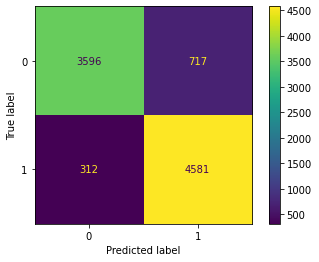

In [ ]:
print_confusion_matrix(classifier, train_set, train_label)

72/72 [==============================] - 0s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


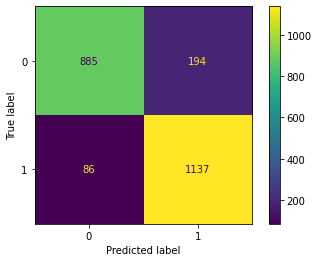

In [ ]:
print_confusion_matrix(classifier, test_set, test_label)

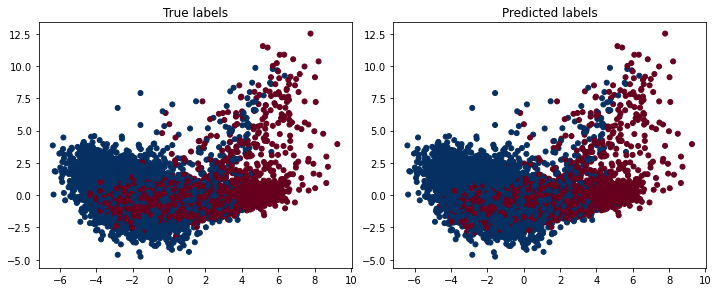

In [ ]:
print_scatter(train_set, train_label, train_pred)

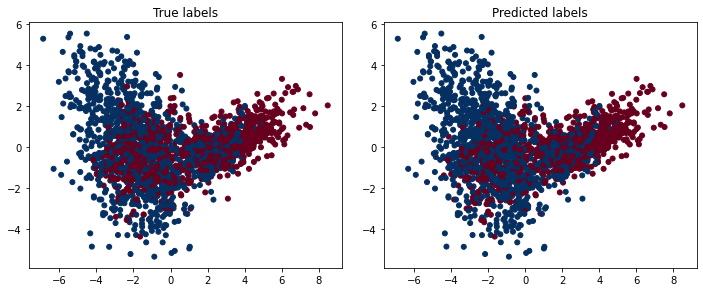

In [ ]:
print_scatter(test_set, test_label, test_pred)

In [ ]:
filename = "./model_8_16.sav"
pickle.dump(model, open(filename, 'wb'))
!cp model_8_16.sav /content/drive/Shareddrives/DM_Project/models